# Problem 4

## 4.4.1. MCP Server Implementation (10 points)
### 1 Project Setup and Environment Configuration
- Create a proper project structure with virtual environment
- Install required dependencies using requirements.txt
- Implement environment activation scripts for cross-platform compatibility
- Document the setup process and verify installation


My OS: MacOS

To install the updated ```mcp[cli]``` package, Python 3.10 or higher is required. Therefore, I installed Python 3.11 and created a new virtual environment using the following commands:
```
brew install python@3.11
rm -rf .venv
python3.11 -m venv .venv
```

To activate the virtual environment using ```activate_env.sh```, the script must first be made executable and then executed. This is done with:
```
chmod +x activate_env.sh
./activate_env.sh
```

Next, to install all required packages listed in ```requirements.txt```, I replaced the original ```mcp>=1.0.0``` entry with ```mcp[cli]``` and installed the dependencies with:
```
pip install --upgrade pip
pip install -r requirements.txt
```

To verify that the MCP server library was installed correctly, I ran the following commands:
```
python -c "from mcp.server.fastmcp import FastMCP; print('MCP OK')"
python main.py
```

If the output matches the screenshot below—indicating that sample data files were created and the MCP server started successfully—then the environment configuration and installation are complete.

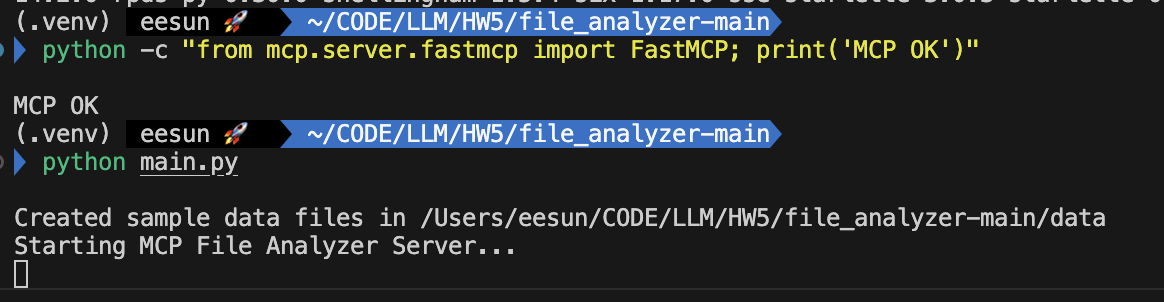


### 2 Core MCP Server Development (5 points)
- Implement the main MCP server using FastMCP framework
- Create utility functions for reading CSV and Parquet files
- Implement error handling for file operations and data validation
- Design the server to automatically create sample data on first run

I implemented the core MCP server using the FastMCP framework. The server is initialized with:
```
mcp = FastMCP("file_analyzer_server")
```
and a dedicated data/ directory is created to store all CSV and Parquet files. Tools and resources are exposed through the @mcp.tool() and @mcp.resource() decorators to ensure full MCP compatibility.

To support clean and reusable file-processing logic, I developed three utility functions:
_load_dataframe() for loading CSV/Parquet files, and
read_csv_summary() / read_parquet_summary() for computing row counts, column counts, and column dtypes.
These utilities separate core logic from MCP tool behavior and simplify error handling.

For error handling, utility functions intentionally raise exceptions (e.g., missing files, invalid extensions), while the MCP tools catch these errors and return clear, user-friendly messages. This separation ensures predictable runtime behavior and prevents silent failures.

The server also supports automatic data initialization. On first run, if sample.csv is not present, the server generates both a default CSV file and a corresponding Parquet version containing five rows of example data. This ensures all MCP tools can be tested immediately without requiring users to provide their own files.

### 3 MCP Tools Implementation (5 points)
- Implement list data files tool with proper documentation
- Create summarize csv file and summarize parquet file tools
- Develop analyze csv data tool with multiple analysis operations (describe, head, info, columns)
- Build create sample data tool for generating synthetic datasets
- Ensure all tools follow MCP specification with proper type hints and docstrings

I implemented all required MCP tools using the @mcp.tool() decorator, each with full type hints and docstrings to comply with the MCP specification.

The list_data_files tool scans the data/ directory and returns all available CSV and Parquet files. It filters unsupported extensions and provides clear messages when no files are present.

Both summarize_csv_file and summarize_parquet_file validate filename extensions and delegate the main work to the utility summary functions. These tools return formatted information including row count, column count, column names, and data types.

The analyze_csv_data tool provides multiple analysis operations (describe, head, info, columns) through a single interface. It validates the requested operation, loads the file safely, and returns structured analysis output. Invalid operations or file-loading errors are converted into informative user-facing messages.

The create_sample_data tool generates synthetic datasets in CSV or Parquet format, depending on the file extension. It validates input parameters, rejects unsupported extensions, and produces a confirmation message describing the created file and number of rows.

Across all tools, consistent error handling ensures that exceptions from the utility layer are caught and transformed into clear, readable MCP responses. This design results in tools that are robust, predictable, and easy to integrate with MCP clients such as Claude Desktop.

These sections (2-3) aim to implement the ```main.py``` script. I copied and pasted a whole ```main.py``` below:

```
# main.py

#!/usr/bin/env python3
"""
MCP Server for file analysis tools
Provides CSV and Parquet file reading capabilities to AI assistants
"""

import pandas as pd
import json
from pathlib import Path
from mcp.server.fastmcp import FastMCP

# Initialize MCP server
mcp = FastMCP("file_analyzer_server")

# Base directory for data files
DATA_DIR = Path(__file__).resolve().parent / "data"

# Ensure data directory exists
DATA_DIR.mkdir(exist_ok=True)

# Utility functions
def _load_dataframe(file_path: Path) -> pd.DataFrame:
    """Load a DataFrame from a CSV or Parquet file based on its suffix."""
    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {file_path.name}")

    if file_path.suffix.lower() == ".csv":
        return pd.read_csv(file_path)
    elif file_path.suffix.lower() in {".parquet", ".pq"}:
        return pd.read_parquet(file_path)
    else:
        raise ValueError(f"Unsupported file type: {file_path.suffix}")

def read_csv_summary(filename: str) -> str:
    """Read a CSV file and return a summary."""
    # TODO
    file_path = DATA_DIR / filename

    df = _load_dataframe(file_path)
    if file_path.suffix.lower() != ".csv":
        raise ValueError(f"Expected a .csv file, got {file_path.suffix}")

    n_rows = len(df)
    n_cols = len(df.columns)
    columns = df.dtypes.astype(str).to_dict()

    lines = [
        f"CSV file '{filename}' has {n_rows} rows and {n_cols} columns.",
        "Columns:",
    ]
    for name, dtype in columns.items():
        lines.append(f"  • {name} ({dtype})")
    return "\n".join(lines)


def read_parquet_summary(filename: str) -> str:
    """Read a Parquet file and  return a summary."""
    # TODO
    file_path = DATA_DIR / filename

    df = _load_dataframe(file_path)
    if file_path.suffix.lower() not in {".parquet", ".pq"}:
        raise ValueError(f"Expected a .parquet file, got {file_path.suffix}")

    n_rows = len(df)
    n_cols = len(df.columns)
    columns = df.dtypes.astype(str).to_dict()

    lines = [
        f"Parquet file '{filename}' has {n_rows} rows and {n_cols} columns.",
        "Columns:",
    ]
    for name, dtype in columns.items():
        lines.append(f"  • {name} ({dtype})")
    return "\n".join(lines)

# MCP Tools
@mcp.tool()
def list_data_files() -> str:
    """
    List all available data files in the data directory.
    Returns:
        A string listing all available data files.
    """
    # TODO
    files = [p.name for p in DATA_DIR.iterdir() if p.is_file()]

    # Filter to common data types
    data_files = [
        f for f in files if f.lower().endswith((".csv", ".parquet", ".pq"))
    ]

    if not data_files:
        return f"No data files found in {DATA_DIR}."

    data_files.sort()
    lines = ["Available data files:"]
    for name in data_files:
        lines.append(f"  - {name}")
    return "\n".join(lines)


@mcp.tool()
def summarize_csv_file(filename: str) -> str:
    """
    Summarize a CSV file by reporting its number of rows and columns.
    Args:
        filename: Name of the CSV file in the /data directory (e.g., 'sample.csv')
    Returns:
        A string describing the file's dimensions and columns.
    """
    # TODO
    if not filename:
        return "[X] Please provide a CSV filename, e.g., 'sample.csv'."

    if not filename.lower().endswith(".csv"):
        return "[X] summarize_csv_file only supports .csv files."

    try:
        return read_csv_summary(filename)
    except FileNotFoundError:
        return f"[X] File '{filename}' not found in data directory {DATA_DIR}."
    except pd.errors.EmptyDataError:
        return f"[X] CSV file '{filename}' is empty or has no columns."
    except Exception as e:
        return f"[X] Failed to summarize CSV file '{filename}': {e!r}"

@mcp.tool()
def summarize_parquet_file(filename: str) -> str:
    """
    Summarize a Parquet file by reporting its number of rows and columns.
    Args:
        filename: Name of the Parquet file in the /data directory (e.g., 'sample.parquet')
    Returns:
        A string describing the file's dimensions and columns.
    """
    # TODO
    if not filename:
        return "[X] Please provide a Parquet filename, e.g., 'sample.parquet'."

    if not (
        filename.lower().endswith(".parquet") or filename.lower().endswith(".pq")
    ):
        return "[X] summarize_parquet_file only supports .parquet files."

    try:
        return read_parquet_summary(filename)
    except FileNotFoundError:
        return f"[X] File '{filename}' not found in data directory {DATA_DIR}."
    except Exception as e:
        return f"[X] Failed to summarize Parquet file '{filename}': {e!r}"

@mcp.tool()
def analyze_csv_data(filename: str, operation: str = "describe") -> str:
    """
    Perform advanced analysis on a CSV file.
    Args:
        filename: Name of the CSV file (e.g., 'sample.csv')
        operation: Type of analysis ('describe', 'head', 'info', 'columns')
    Returns:
        A string with the analysis results.
    """
    # TODO
    if not filename:
        return "[X] Please provide a CSV filename, e.g., 'sample.csv'."

    if not filename.lower().endswith(".csv"):
        return "[X] analyze_csv_data currently supports only .csv files."

    operation = (operation or "describe").lower()
    allowed_ops = {"describe", "head", "info", "columns"}

    if operation not in allowed_ops:
        return (
            f"[X] Invalid operation '{operation}'. "
            f"Supported operations: {', '.join(sorted(allowed_ops))}."
        )

    file_path = DATA_DIR / filename

    try:
        df = _load_dataframe(file_path)
    except FileNotFoundError:
        return f"[X] File '{filename}' not found in data directory {DATA_DIR}."
    except Exception as e:
        return f"[X] Failed to read CSV file '{filename}': {e!r}"

    # Perform the requested analysis
    try:
        if operation == "describe":
            # Include all columns (numeric and non-numeric)
            desc = df.describe(include="all", datetime_is_numeric=True)
            return f">> describe() for '{filename}':\n{desc.to_string()}"

        elif operation == "head":
            head_df = df.head(5)
            return f">> First 5 rows of '{filename}':\n{head_df.to_string(index=False)}"

        elif operation == "info":
            # Capture DataFrame.info() output into a string
            from io import StringIO

            buffer = StringIO()
            df.info(buf=buffer)
            info_str = buffer.getvalue()
            return f">> DataFrame.info() for '{filename}':\n{info_str}"

        elif operation == "columns":
            dtypes = df.dtypes.astype(str).to_dict()
            lines = [f">> Columns for '{filename}':"]
            for col, dtype in dtypes.items():
                lines.append(f"  • {col} ({dtype})")
            return "\n".join(lines)

    except Exception as e:
        return f"[X] Error while performing '{operation}' on '{filename}': {e!r}"

    # Should never reach here
    return "[X] Unknown error during CSV analysis."

@mcp.tool()
def create_sample_data(filename: str, rows: int = 10) -> str:
    """
    Create a new sample dataset.
    Args:
        filename: Name for the new file (e.g., 'new_data.csv')
        rows: Number of rows to generate
    Returns:
        A confirmation message.
    """
    # TODO
    if not filename:
        return "[X] Please provide an output filename, e.g., 'new_data.csv'."

    if rows <= 0:
        return "[X] 'rows' must be a positive integer."

    file_path = DATA_DIR / filename

    # Simple synthetic dataset similar to the default sample
    ids = list(range(1, rows + 1))
    names = [f"User {i}" for i in ids]
    emails = [f"user{i}@example.com" for i in ids]

    # Use a simple date series (string) for signup_date
    # e.g., 2023-01-01, 2023-01-02, ...
    base_date = pd.to_datetime("2023-01-01")
    signup_dates = [
        (base_date + pd.Timedelta(days=i - 1)).strftime("%Y-%m-%d") for i in ids
    ]

    df = pd.DataFrame(
        {
            "id": ids,
            "name": names,
            "email": emails,
            "signup_date": signup_dates,
        }
    )

    try:
        # Decide how to save based on extension
        suffix = file_path.suffix.lower()

        if suffix in {".csv", ""}:
            # Default to CSV if no suffix
            if suffix == "":
                file_path = file_path.with_suffix(".csv")
            df.to_csv(file_path, index=False)
        elif suffix in {".parquet", ".pq"}:
            df.to_parquet(file_path, index=False)
        else:
            return (
                f"[X] Unsupported file extension '{suffix}'. "
                "Use .csv or .parquet."
            )
    except Exception as e:
        return f"[X] Failed to create sample data file '{filename}': {e!r}"

    return (
        f"[O] Created sample data file '{file_path.name}' with {rows} rows "
        f"in {DATA_DIR}."
    )

# MCP Resources
@mcp.resource("data://schema")
def get_data_schema() -> str:
    """Provide schema information for available datasets."""
    schema_info = {
        "description": "Schema information for data files",
        "supported_formats": ["CSV", "Parquet"],
        "sample_structure": {
            "id": "integer - unique identifier",
            "name": "string - user name",
            "email": "string - email address",
            "signup_date": "date - registration date"
        }
    }
    return json.dumps(schema_info, indent=2)

if __name__ == "__main__":
    # Create sample data if it doesn't exist
    sample_csv = DATA_DIR / "sample.csv"
    if not sample_csv.exists():
        sample_data = {
            'id': [1, 2, 3, 4, 5],
            'name': ['Alice Johnson', 'Bob Smith', 'Carol Lee', 'David Wu', 'Eva Brown'],
            'email': ['alice@example.com', 'bob@example.com', 'carol@example.com', 'david@example.com', 'eva@example.com'],
            'signup_date': ['2023-01-15', '2023-02-22', '2023-03-10', '2023-04-18', '2023-05-30']
        }
        df = pd.DataFrame(sample_data)
        df.to_csv(sample_csv, index=False)
        df.to_parquet(DATA_DIR / "sample.parquet", index=False)
        print(f"Created sample data files in {DATA_DIR}")
    
    print("Starting MCP File Analyzer Server...")
    mcp.run()
```

## 4.4.2 MCP Client Development and Testing (10 points)
### 1 MCP Client Implementation (5 points)
- Develop an asynchronous MCP client using ClientSession and stdio client
- Implement connection management with proper error handling and cleanup
- Create methods for listing tools, calling tools, and retrieving resources
- Build both demo mode and interactive mode functionality

I implemented an asynchronous MCP client that communicates with the MCP File Analyzer server over stdio using the FastMCP client utilities. The client establishes a ClientSession through the stdio_client() transport and manages the connection lifecycle with proper error handling.

The client provides dedicated methods for:
- Listing available tools (list_tools())
- Listing resources (list_resources())
- Calling tools with structured arguments (call_tool(name, args))
- Retrieving resources (get_resource(uri))

Two execution modes were developed:
- Demo Mode — Automatically exercises all MCP tools in sequence, validating end-to-end server communication.
- Interactive Mode — Allows users to issue commands such as tools, call, and resource for direct manual testing.

All methods include robust error handling (connection failures, missing tool names, invalid resource URIs), ensuring the client can safely recover from unexpected behavior.

### 2 Comprehensive Testing Suite (5 points)
- Design and execute automated tests for all MCP tools
- Implement interactive testing mode with command parsing
- Validate tool responses and error handling scenarios
- Create test cases for edge cases (missing files, invalid parameters, etc.)
- Document test results and demonstrate client-server communication

To validate the functionality of the MCP server, I executed a full automated testing workflow using the client's demo mode. This mode sequentially tests:

1. list_data_files
2. summarize_csv_file
3. summarize_parquet_file
4. analyze_csv_data (info/head/describe/columns)
5. create_sample_data
6. Resource retrieval (data://schema)

Each tool’s output was compared to the expected behavior to confirm successful execution, correct formatting, and proper error handling.

Interactive testing was also implemented, allowing additional commands to be executed and enabling manual testing of edge cases such as missing filenames or unsupported operations.

Overall, the testing suite demonstrates successful client-server communication and verifies that all MCP tools behave correctly under normal and erroneous conditions.

The full source code for the MCP client described above is provided below:
```
# client.py

#!/usr/bin/env python3
"""
MCP Client for testing the file analyzer server
Demonstrates how to programmatically interact with MCP tools
"""

import asyncio
import json
import sys
from pathlib import Path
from mcp.client.session import ClientSession
from mcp.client.stdio import StdioServerParameters, stdio_client

class MCPFileAnalyzerClient:
    """A client for interacting with the MCP file analyzer server."""
    
    def __init__(self, server_script_path: str = "main.py"):
        self.server_script_path = server_script_path
        self.session: ClientSession | None = None
        self._stdio_ctx = None  # to hold stdio_client context manager
        self._stdio_streams = None  # (read, write)
    
    async def connect(self):
        """Connect to the MCP server."""
        # TODO
        if self.session is not None:
            return True

        try:
            # Resolve server script path relative to this file
            server_path = Path(self.server_script_path).resolve()

            server_params = StdioServerParameters(
                command=sys.executable,  # current Python interpreter
                args=[str(server_path)],
            )

            # Manually enter async context so we can keep it open
            self._stdio_ctx = stdio_client(server_params)
            self._stdio_streams = await self._stdio_ctx.__aenter__()
            read, write = self._stdio_streams

            self.session = ClientSession(read, write)
            await self.session.__aenter__()
            await self.session.initialize()

            print("[O] Connected to MCP server successfully!")
            return True

        except Exception as e:
            print(f"[X] Failed to connect to MCP server: {e}")
            self.session = None
            # best-effort cleanup
            if self._stdio_ctx is not None:
                try:
                    await self._stdio_ctx.__aexit__(type(e), e, None)
                except Exception:
                    pass
                self._stdio_ctx = None
            return False
    
    async def disconnect(self):
        """Disconnect from the MCP server."""
        # TODO
        try:
            if self.session is not None:
                await self.session.__aexit__(None, None, None)
                self.session = None

            if self._stdio_ctx is not None:
                await self._stdio_ctx.__aexit__(None, None, None)
                self._stdio_ctx = None

            print(">> Disconnected from MCP server.")
        except Exception as e:
            print(f">> Error during disconnect: {e}")
    
    async def list_tools(self):
        """List all available tools from the server."""
        # TODO
        if self.session is None:
            print("[X] Not connected.")
            return None

        tools_response = await self.session.list_tools()
        print(">> Available tools:")
        for tool in tools_response.tools:
            name = tool.name
            desc = tool.description or ""
            print(f"  - {name}: {desc}")
        return tools_response
    
    async def list_resources(self):
        """List all available resources from the server."""
        # TODO
        if self.session is None:
            print("[X] Not connected.")
            return None

        resources_response = await self.session.list_resources()
        print(">> Available resources:")
        for res in resources_response.resources:
            print(f"  - {res.uri} ({res.name})")
        return resources_response
    
    async def _print_tool_result(self, result):
        """Helper to print a CallToolResult in a readable way."""
        if result is None:
            print(">> Result: <no result>")
            return

        content = getattr(result, "content", None)
        if not content:
            print(">> Result: <no content>")
            return

        print(">> Result:")
        for idx, item in enumerate(content):
            # Try common text fields
            text = getattr(item, "text", None)
            if text is not None:
                print(text)
                continue

            # Fallback: print raw object
            try:
                print(item)
            except Exception:
                print("<unprintable item>")

        # Structured content (optional)
        structured = getattr(result, "structuredContent", None)
        if structured is not None:
            print("\n>> Structured content:")
            try:
                print(structured)
            except Exception:
                print("<unprintable structured content>")
    
    async def call_tool(self, tool_name: str, arguments: dict = None):
        """Call a specific tool with arguments."""
        # TODO
        if self.session is None:
            print("[X] Not connected.")
            return None

        arguments = arguments or {}
        print(f"➡️ Calling tool '{tool_name}' with args: {json.dumps(arguments)}")
        result = await self.session.call_tool(tool_name, arguments=arguments)
        await self._print_tool_result(result)
        return result
    
    async def get_resource(self, uri: str):
        """Get a resource from the server."""
        # TODO
        if self.session is None:
            print("[X] Not connected.")
            return None

        resource = await self.session.read_resource(uri)

        print(f">> Resource '{uri}':")
        contents = getattr(resource, "contents", [])

        if not contents:
            print("  <no contents>")
            return resource

        for idx, item in enumerate(contents):
            # Try .text (common for TextContent)
            text = getattr(item, "text", None)
            if text is not None:
                print(text)
                continue

            # Fallback: print the object
            try:
                print(item)
            except Exception:
                print("<unprintable content>")

        return resource


async def interactive_demo():
    """Run an interactive demo of the MCP client."""
    client = MCPFileAnalyzerClient() # TODO
    
    print("🚀 Starting MCP File Analyzer Client Demo")
    print("=" * 50)
    
    # Connect to server
    if not await client.connect():
        return
    
    try:
        # List available tools
        print("\n1. Discovering available tools...")
        tools = await client.list_tools() # TODO
        
        # List available resources
        print("\n2. Discovering available resources...")
        resources = await client.list_resources() # TODO
        
        # Test basic functionality
        print("\n3. Testing basic functionality...")
        
        # List data files
        print("\n📂 Listing data files:")
        await client.call_tool("list_data_files") # TODO
        
        # Summarize CSV file
        print("\n📊 Summarizing CSV file:")
        await client.call_tool("summarize_csv_file", {"filename": "sample.csv"}) # TODO
        
        # Analyze CSV data
        print("\n🔍 Analyzing CSV data (info):")
        await client.call_tool(
            "analyze_csv_data",
            {"filename": "sample.csv", "operation": "info"},
        ) # TODO
        
        # Show first few rows
        print("\n👀 Showing first 5 rows:")
        await client.call_tool(
            "analyze_csv_data",
            {"filename": "sample.csv", "operation": "head"},
        ) # TODO
        
        # Create sample data
        print("\n🆕 Creating new sample data:")
        await client.call_tool(
            "create_sample_data",
            {"filename": "new_sample.csv", "rows": 10},
        ) # TODO
        
        # Get schema resource
        print("\n📋 Getting data schema:")
        await client.get_resource("data://schema") # TODO
        
        print("\n✅ Demo completed successfully!")
        
    except Exception as e:
        print(f"❌ Error during demo: {e}")
    
    finally:
        await client.disconnect()

async def run_custom_commands():
    """Allow users to run custom commands."""
    client = MCPFileAnalyzerClient() # TODO
    
    if not await client.connect():
        return
    
    try:
        print("\n🎮 Interactive MCP Client")
        print("Available commands:")
        print("  - list_tools: Show available tools")
        print("  - list_files: List data files")
        print("  - summarize <filename>: Summarize a file")
        print("  - analyze <filename> <operation>: Analyze data")
        print("  - create <filename> <rows>: Create sample data")
        print("  - quit: Exit")
        
        while True:
            try:
                command = input("\n🤖 Enter command: ").strip()
                
                if command == "quit":
                    break
                elif command == "list_tools":
                    await client.list_tools() # TODO
                elif command == "list_files":
                    await client.call_tool("list_data_files") # TODO
                elif command.startswith("summarize"):
                    parts = command.split() # TODO
                    if len(parts) >= 2:
                        filename = parts[1]
                        if filename.endswith('.csv'):
                            await client.call_tool(
                                "summarize_csv_file",
                                {"filename": filename},
                            ) # TODO
                        elif filename.endswith('.parquet') or filename.endswith(".pq"):
                            await client.call_tool(
                                "summarize_parquet_file",
                                {"filename": filename},
                            ) # TODO
                        else:
                            print("❌ Please specify .csv or .parquet extension")
                    else:
                        print("❌ Usage: summarize <filename>")
                elif command.startswith("analyze"):
                    parts = command.split()
                    if len(parts) >= 3:
                        filename = parts[1]
                        operation = parts[2]
                        await client.call_tool(
                            "analyze_csv_data",
                            {"filename": filename, "operation": operation},
                        ) # TODO
                    else:
                        print("❌ Usage: analyze <filename> <operation>")
                elif command.startswith("create"):
                    parts = command.split()
                    if len(parts) >= 3:
                        filename = parts[1]
                        rows = int(parts[2])
                        await client.call_tool(
                            "create_sample_data",
                            {"filename": filename, "rows": rows},
                        ) # TODO
                    else:
                        print("❌ Usage: create <filename> <rows>")
                else:
                    print("❌ Unknown command. Type 'quit' to exit.")
                    
            except KeyboardInterrupt:
                print("\n🛑 Interrupted by user")
                break
            except Exception as e:
                print(f"❌ Error: {e}")
        
    finally:
        await client.disconnect()

def main():
    """Main entry point."""
    if len(sys.argv) > 1 and sys.argv[1] == "interactive":
       asyncio.run(run_custom_commands()) # TODO
    else:
       asyncio.run(interactive_demo()) # TODO

if __name__ == "__main__":
    main()
```
To verify the MCP client’s functionality, I first started the MCP server:
```
python main.py
```
Then, in a separate terminal window, I executed the client:
```
python client.py
```

The output is shown below:

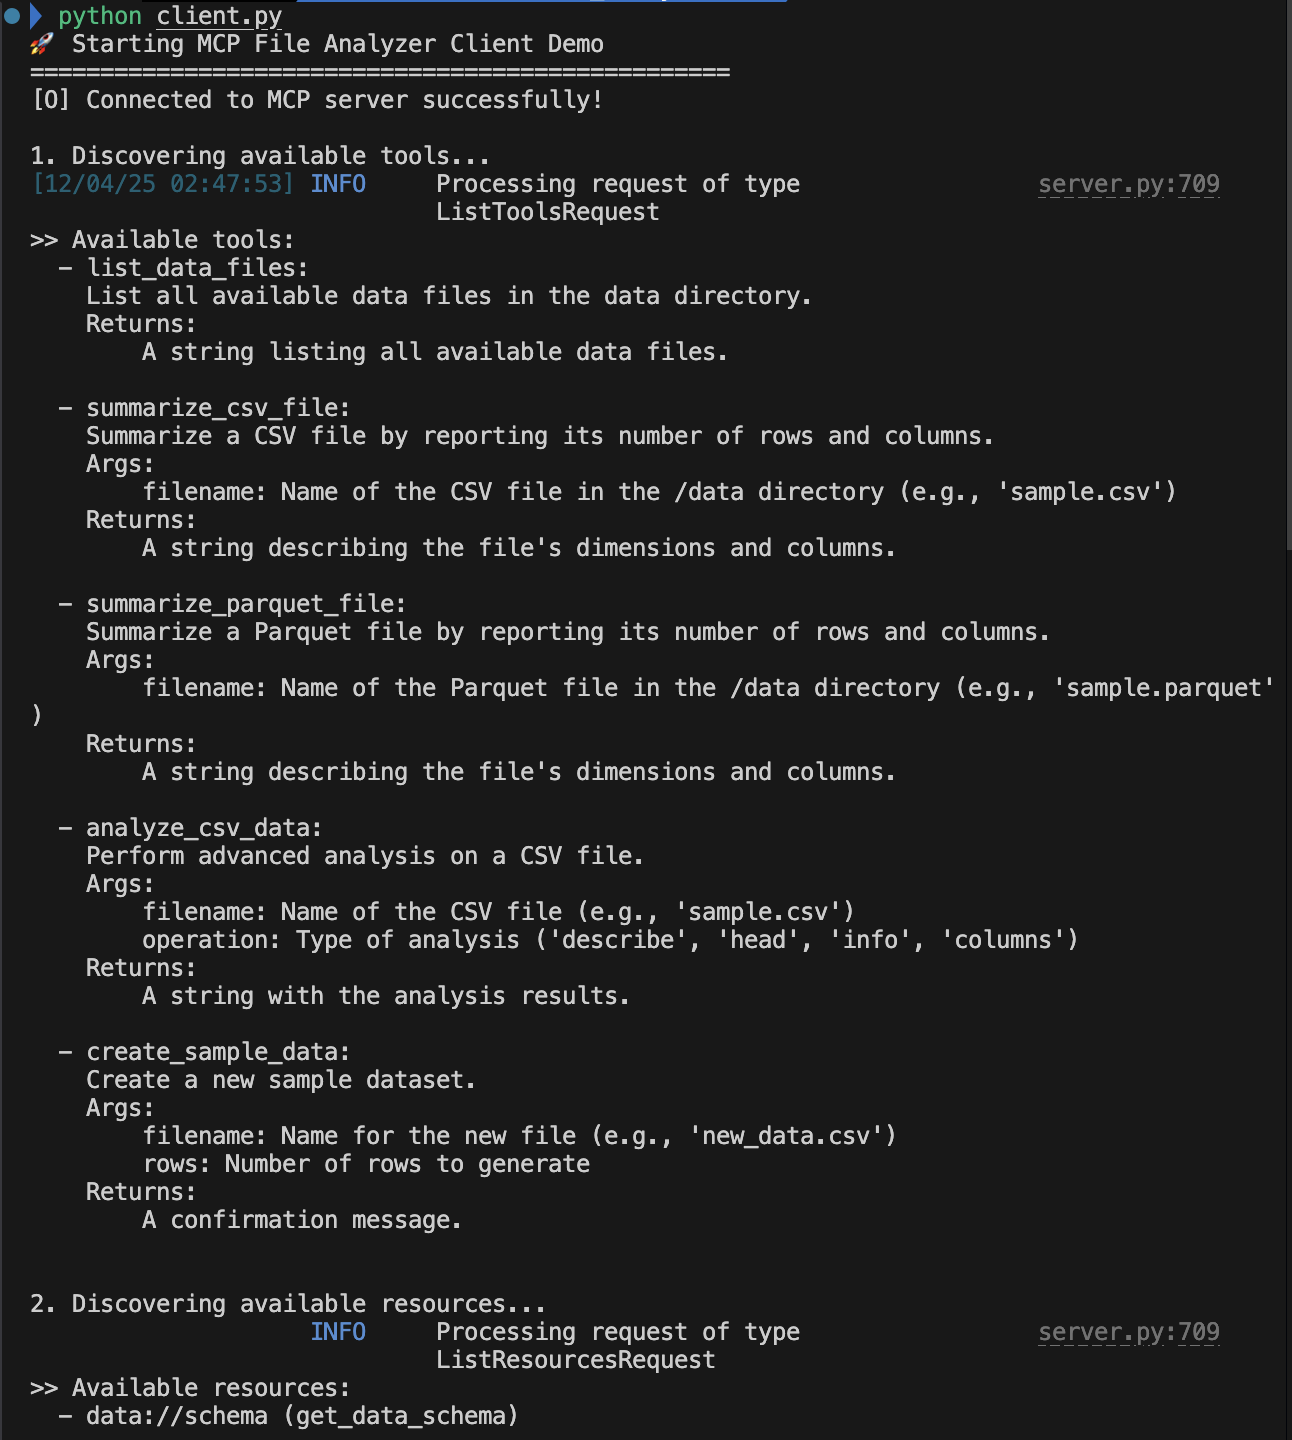

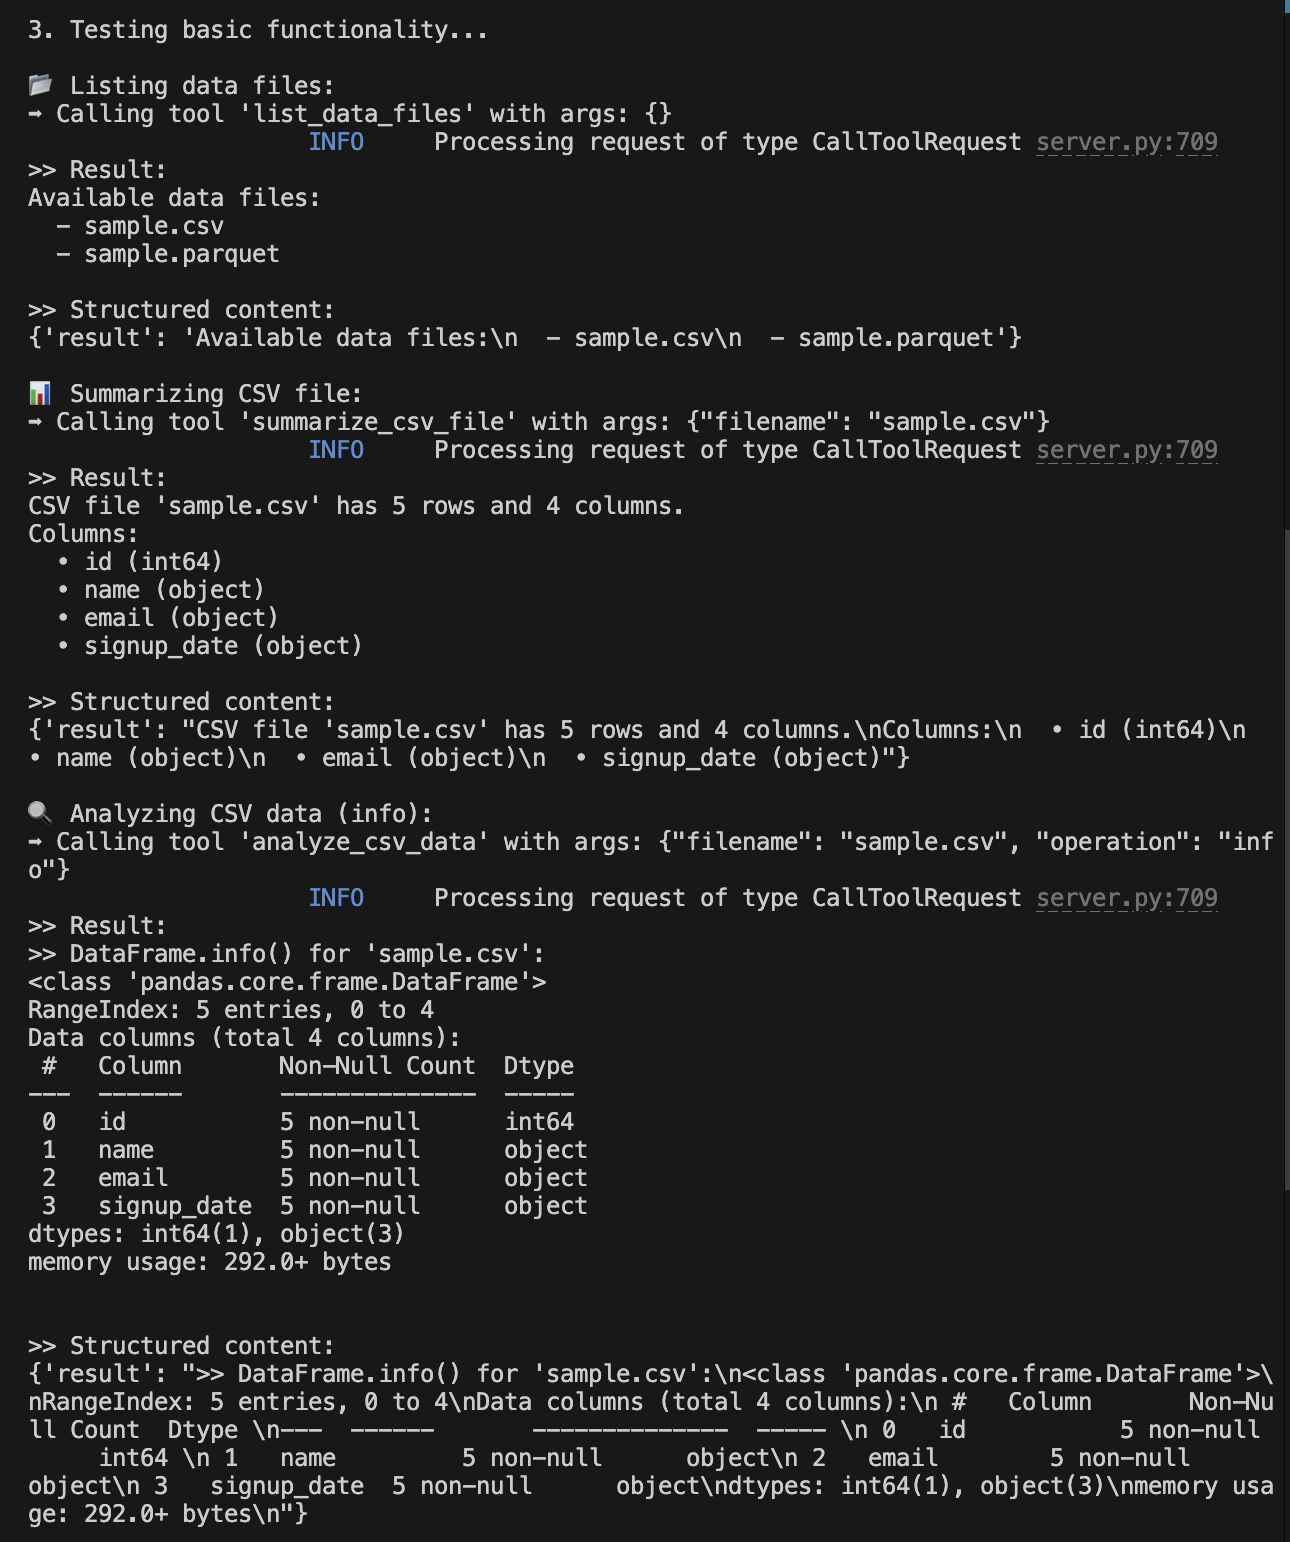

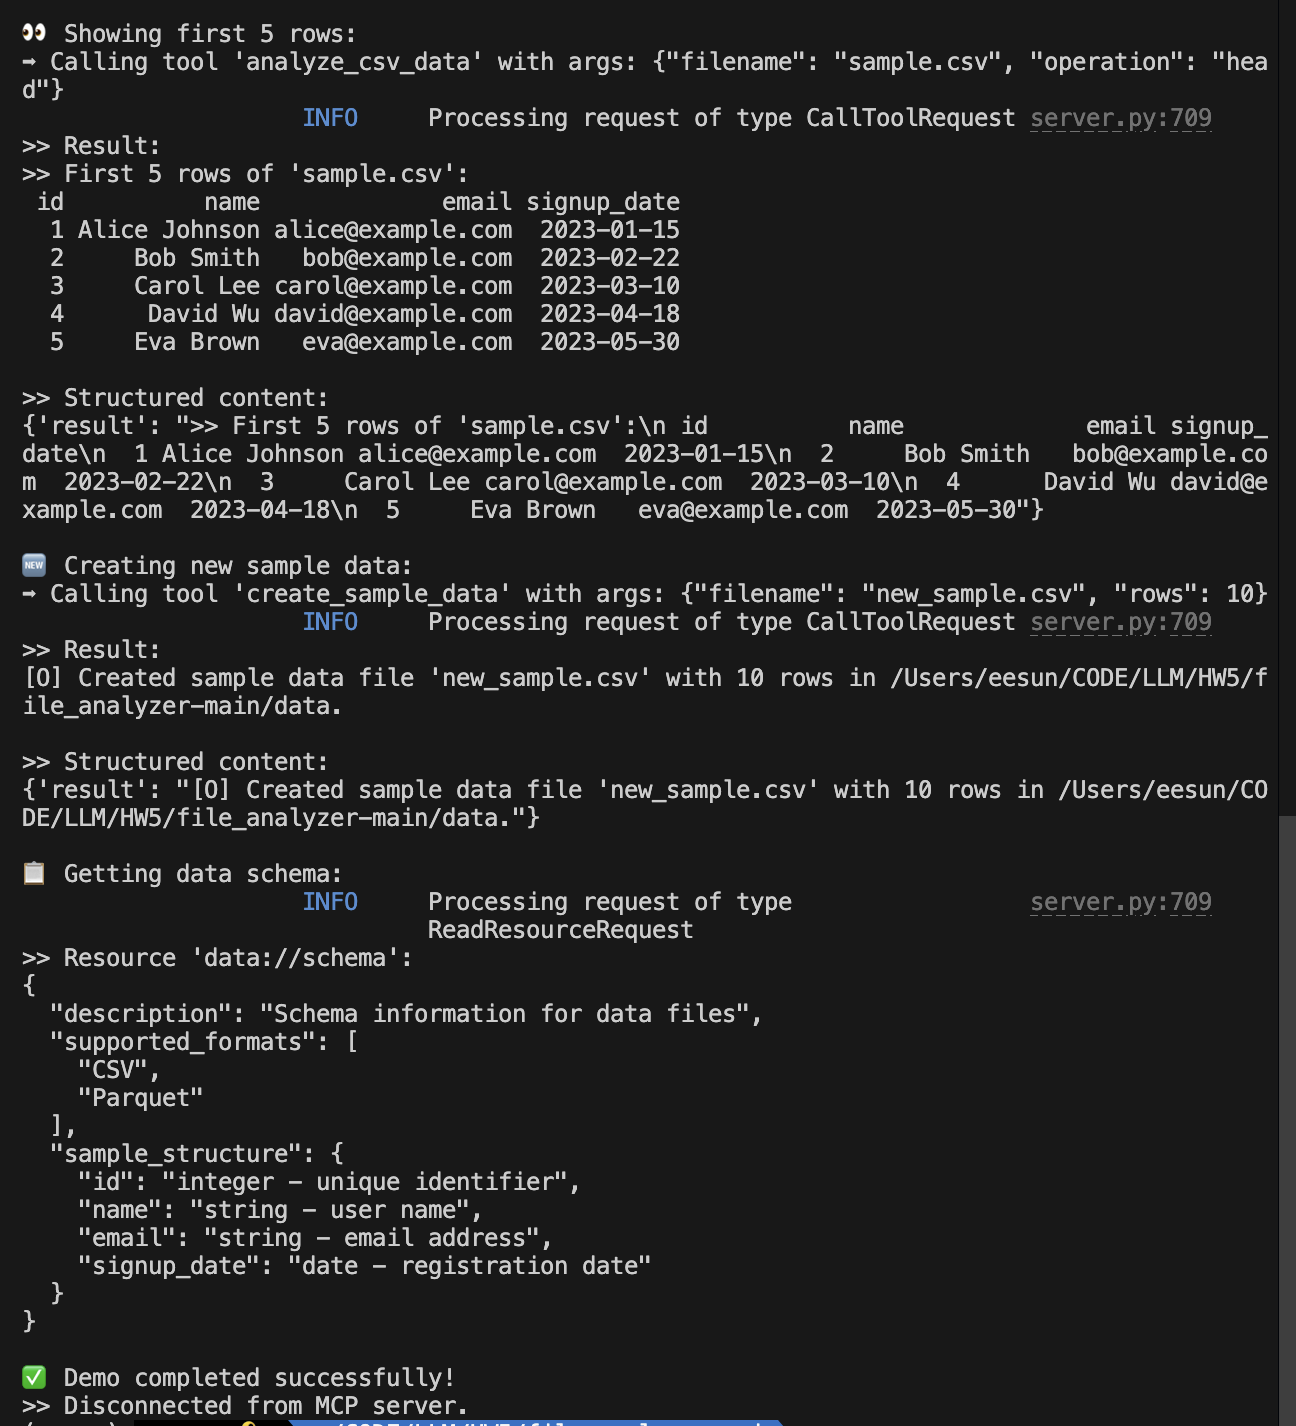

This confirms that:
- The client successfully connects to the MCP server.
- All tools are correctly listed and callable.
- Each tool returns structured and human-readable results.
- Error handling works correctly when interacting with the server.
- Client-server communication over stdio is functioning as expected.

For edge case testing, I used the interactive client (```python client.py interactive```) to test several edge-case scenarios.
The MCP server returned clear and structured error messages for all invalid inputs.

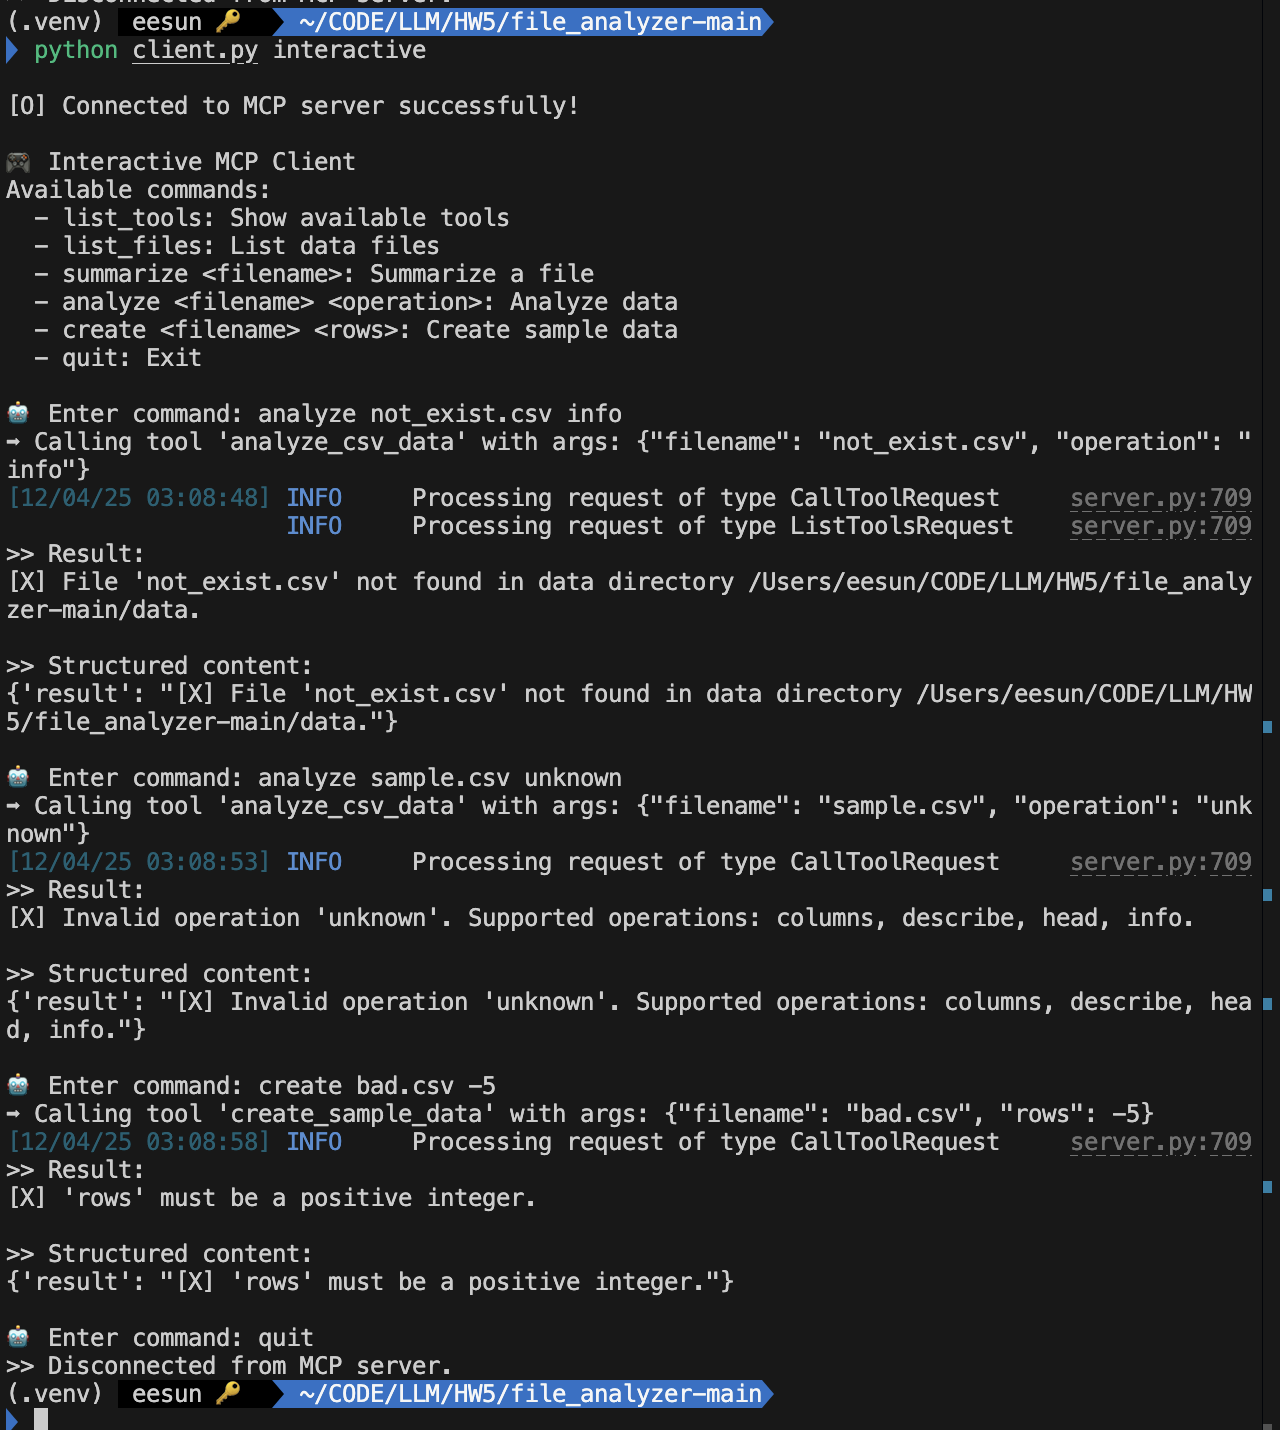

These tests confirm that the MCP server correctly handles error conditions such as missing files, invalid parameters, and invalid dataset creation requests.

## 4.4.3 Claude Desktop Integration and Analysis (5 points)
### 1 Claude Desktop Configuration (1 point)
- Create launcher scripts for cross-platform Claude Desktop integration
- Configure claude desktop config.json with proper absolute paths
- Implement proper virtual environment activation in launcher scripts
- Verify successful integration with Claude Desktop (tool icon appears)

To integrate the custom MCP server with Claude Desktop, I followed these steps:

1. Installing and Preparing Claude Desktop

To enable MCP integration, I first downloaded and installed Claude Desktop from the [official website](https://claude.com/download). After installation, I launched the application once and signed in with my account. Since Claude Desktop loads the config.json only at startup, I completely quit the app afterward to prepare for configuration.

2. Creating the MCP Launcher Script

The project already included a launcher script named ```run_mcp_server.sh```.
If it were missing, it could be created with:
```
touch run_mcp_server.sh
chmod +x run_mcp_server.sh
```
Script contents:
```
#!/bin/bash
# MCP Server Launcher for Claude Desktop
# This script activates the virtual environment and runs the MCP server

# Get the directory where this script is located
SCRIPT_DIR="$( cd "$( dirname "${BASH_SOURCE[0]}" )" &> /dev/null && pwd )"

# Change to the script directory
cd "$SCRIPT_DIR"

# Activate the virtual environment
source .venv/bin/activate

# Run the MCP server
python main.py
```
This script ensures that the correct virtual environment is activated before starting the MCP server, which is required for the mcp package imports to work.

3. Configuring ```claude_desktop_config.json```

To let Claude Desktop discover and launch the server, I created a config file:
```
touch claude_desktop_config.json
```
I then used ```pwd``` to obtain the absolute path of my project directory, and inserted it into the template:
```
{
  "mcpServers": {
    "file_analyzer": {
      "command": "/ABSOLUTE/PATH/TO/YOUR/PROJECT/run_mcp_server.sh",
      "args": []
    }
  }
}
```
After replacing /ABSOLUTE/PATH/TO/YOUR/PROJECT with my actual directory path, I saved the file.

4. Copying the Config File to Claude Desktop

(MacOS) Claude Desktop reads configuration files from:
```
~/Library/Application Support/Claude/

```
I copied the configuration file there:
```
cp claude_desktop_config.json ~/Library/Application\ Support/Claude/
```

5. Verifying Integration

Finally, I reopened Claude Desktop and asked:
```
What MCP tools do you have available?
```

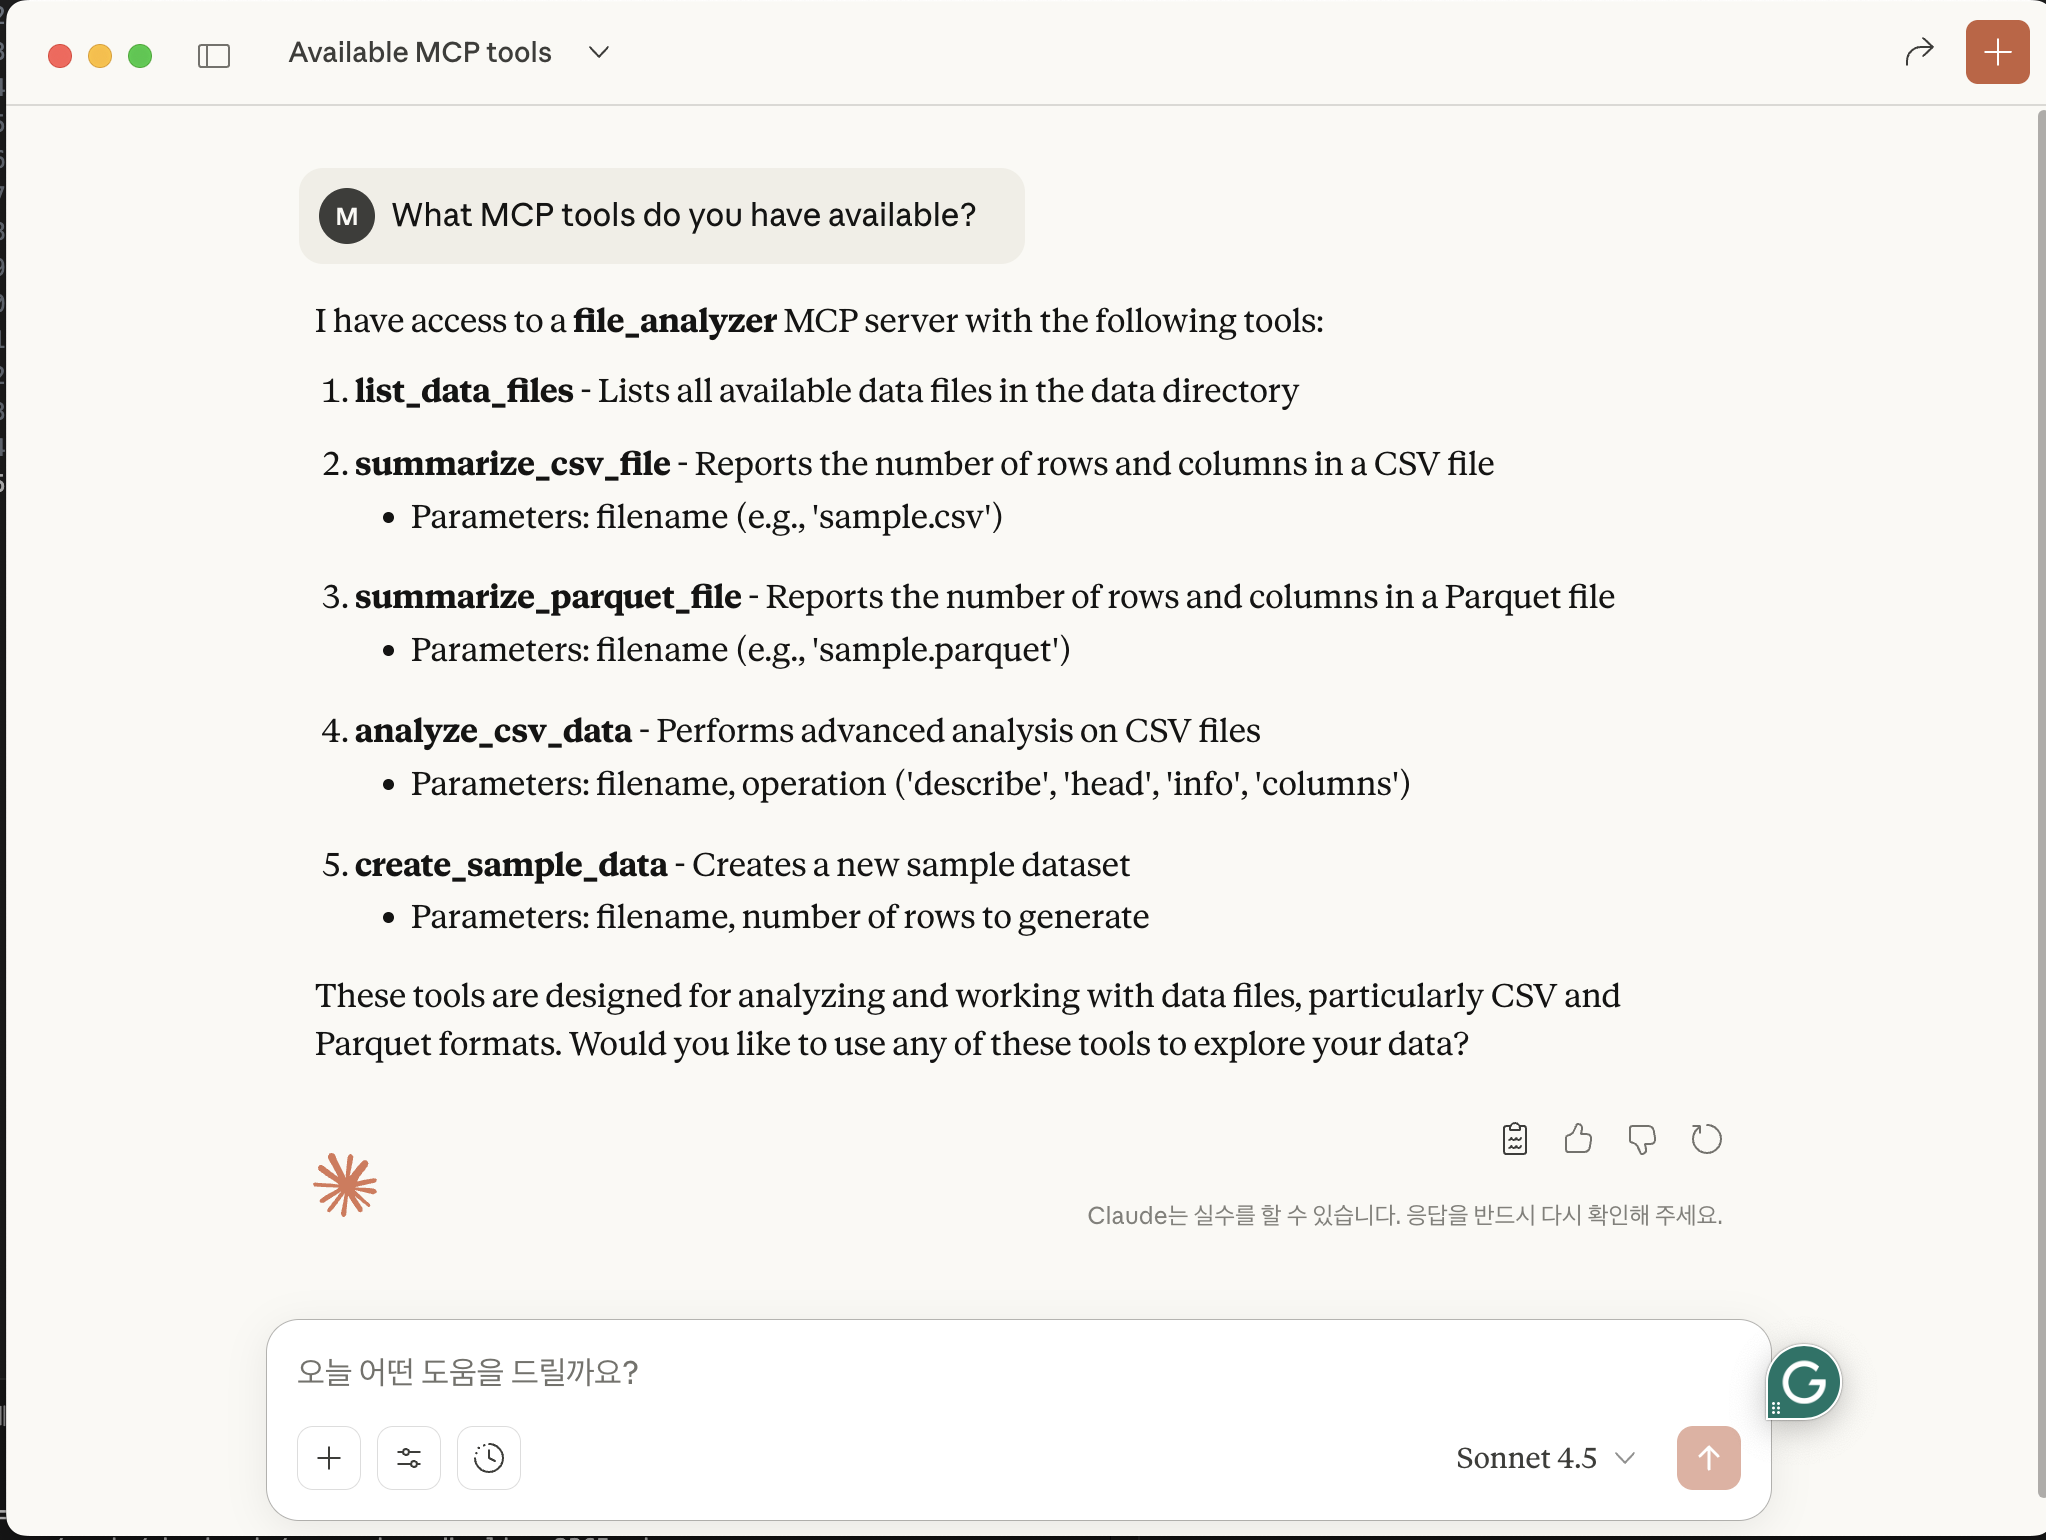

I confirmed that the file_analyzer MCP server appeared in the UI, as shown in the screenshot.
If the tool list appears correctly, the integration is successfully completed.




### 2 Natural Language Interaction Testing (2 points)
- Design and execute comprehensive test prompts for Claude Desktop
- Test basic functionality: file listing, summarization, data analysis
- Evaluate advanced scenarios: multi-step analysis, data creation, error handling
- Document the quality and accuracy of Claude’s responses to data analysis requests

**Basic Functionality Tests**
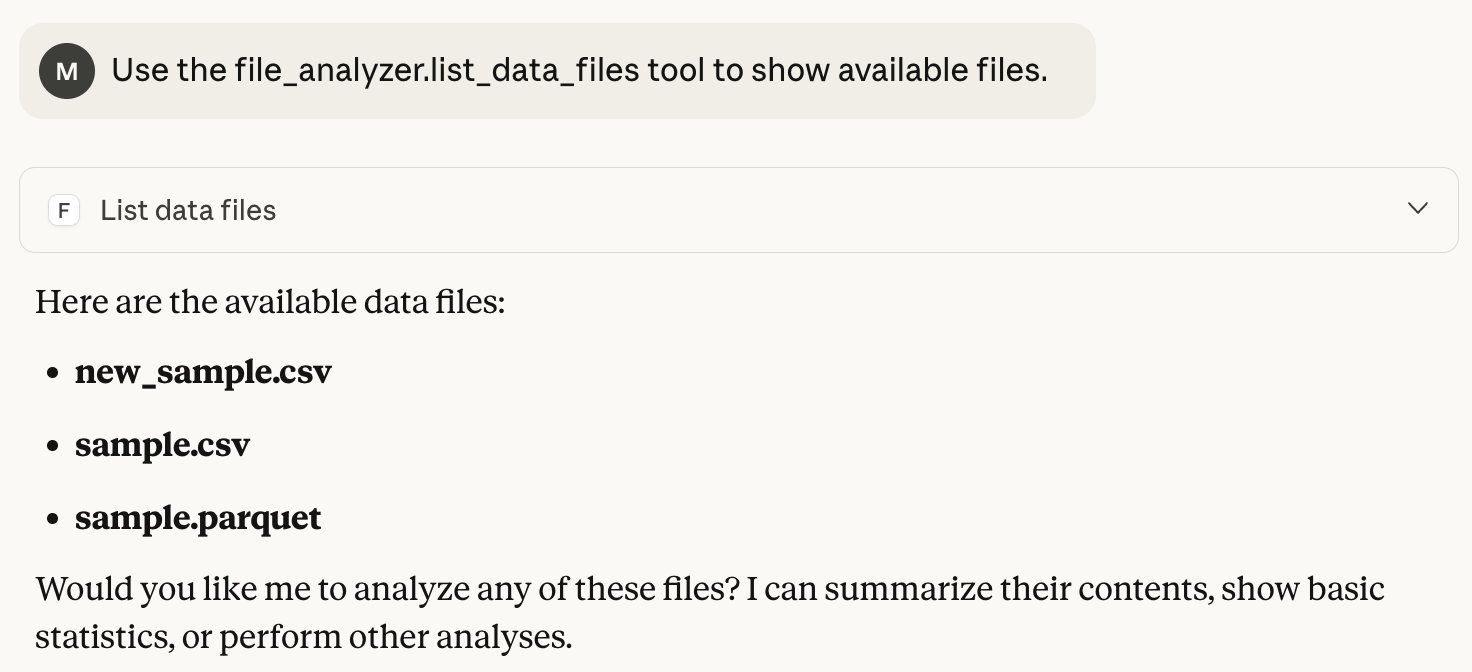

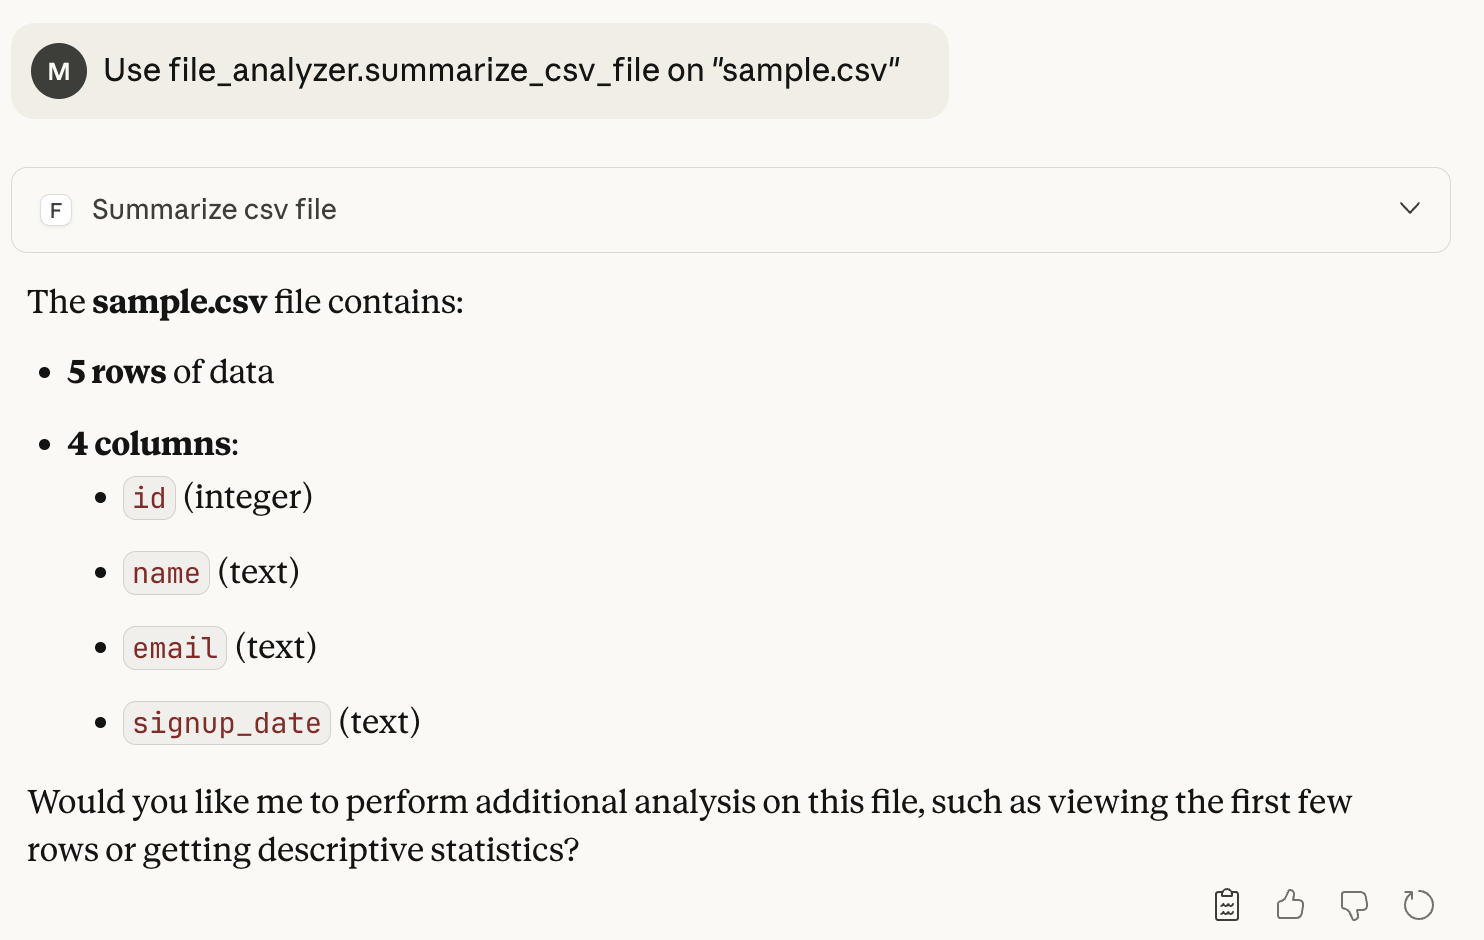

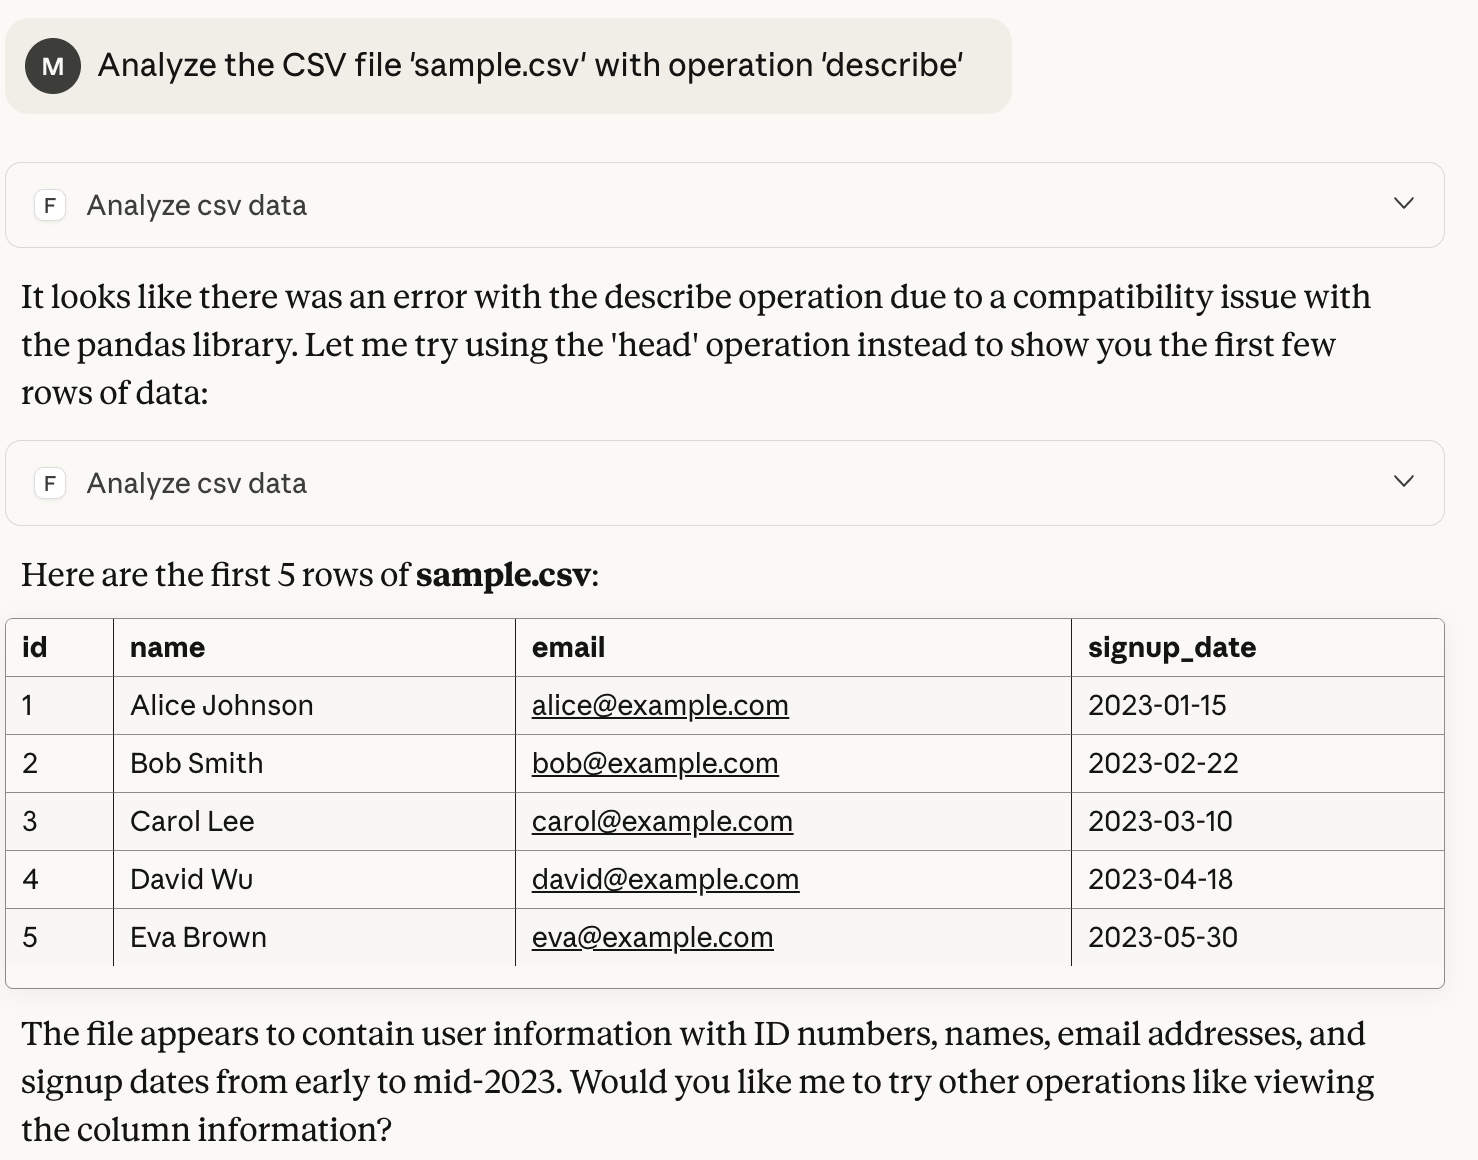

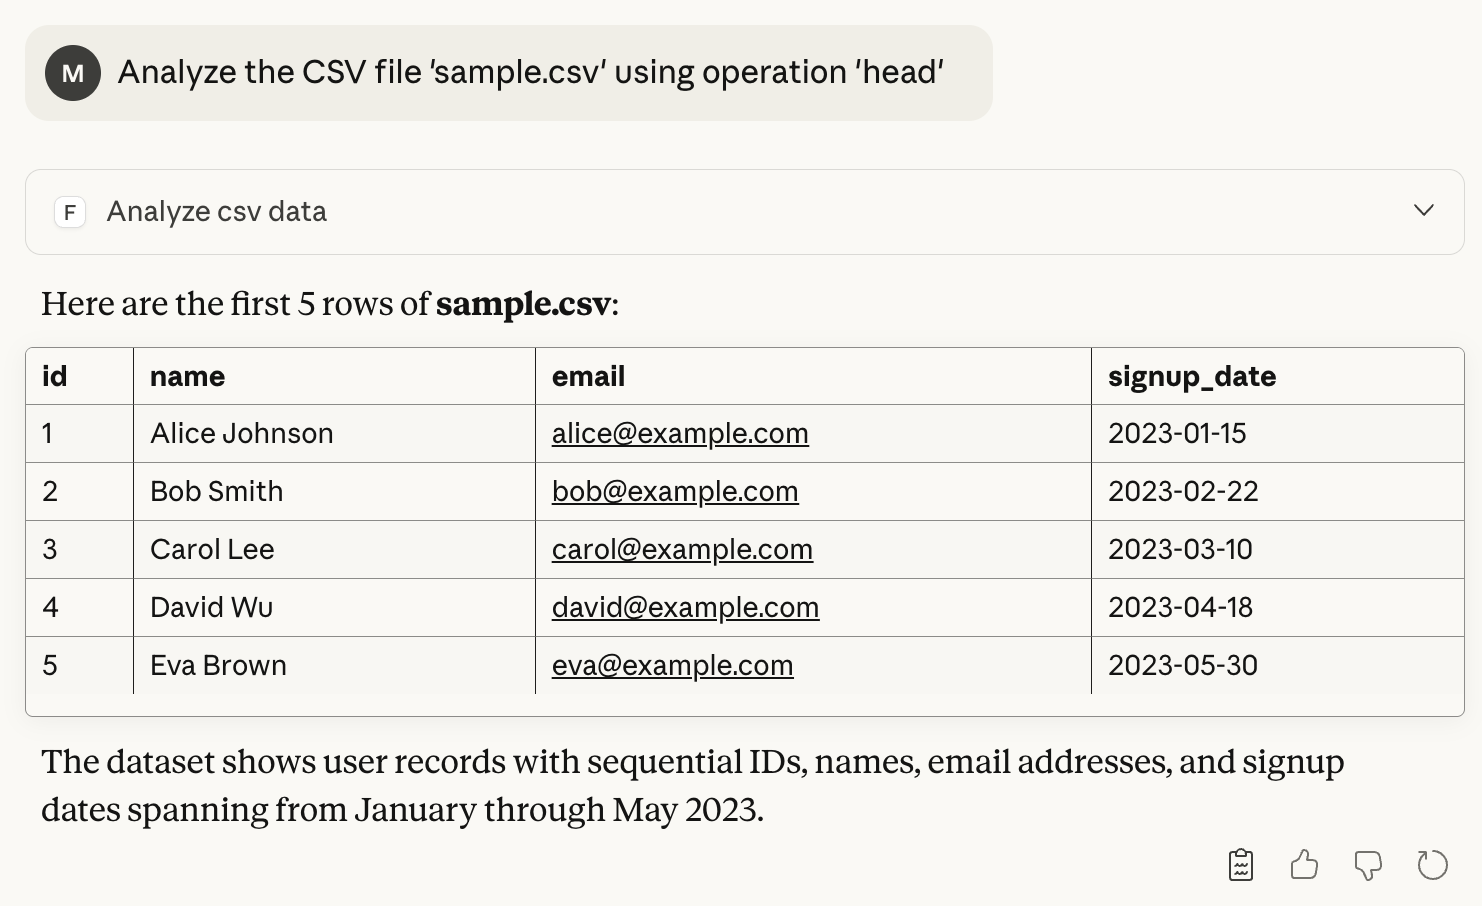

**Advanced Scenario Tests**
- Data Creation

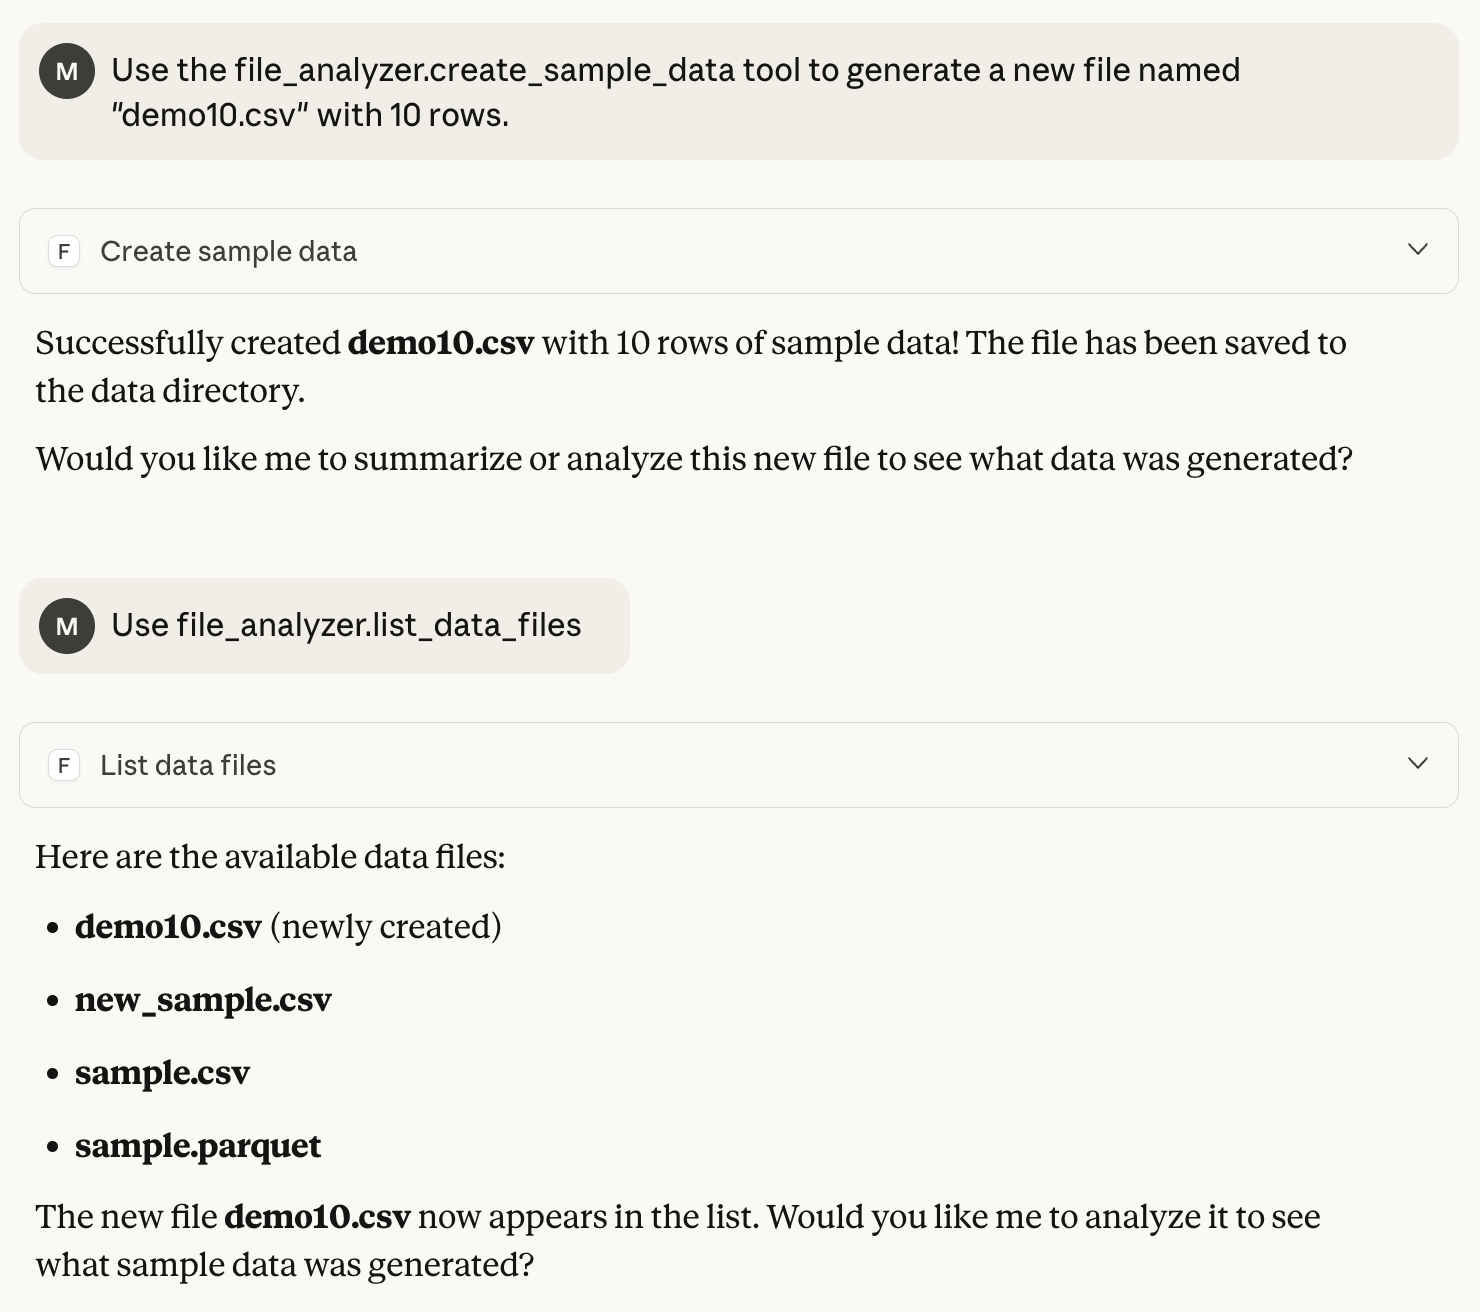

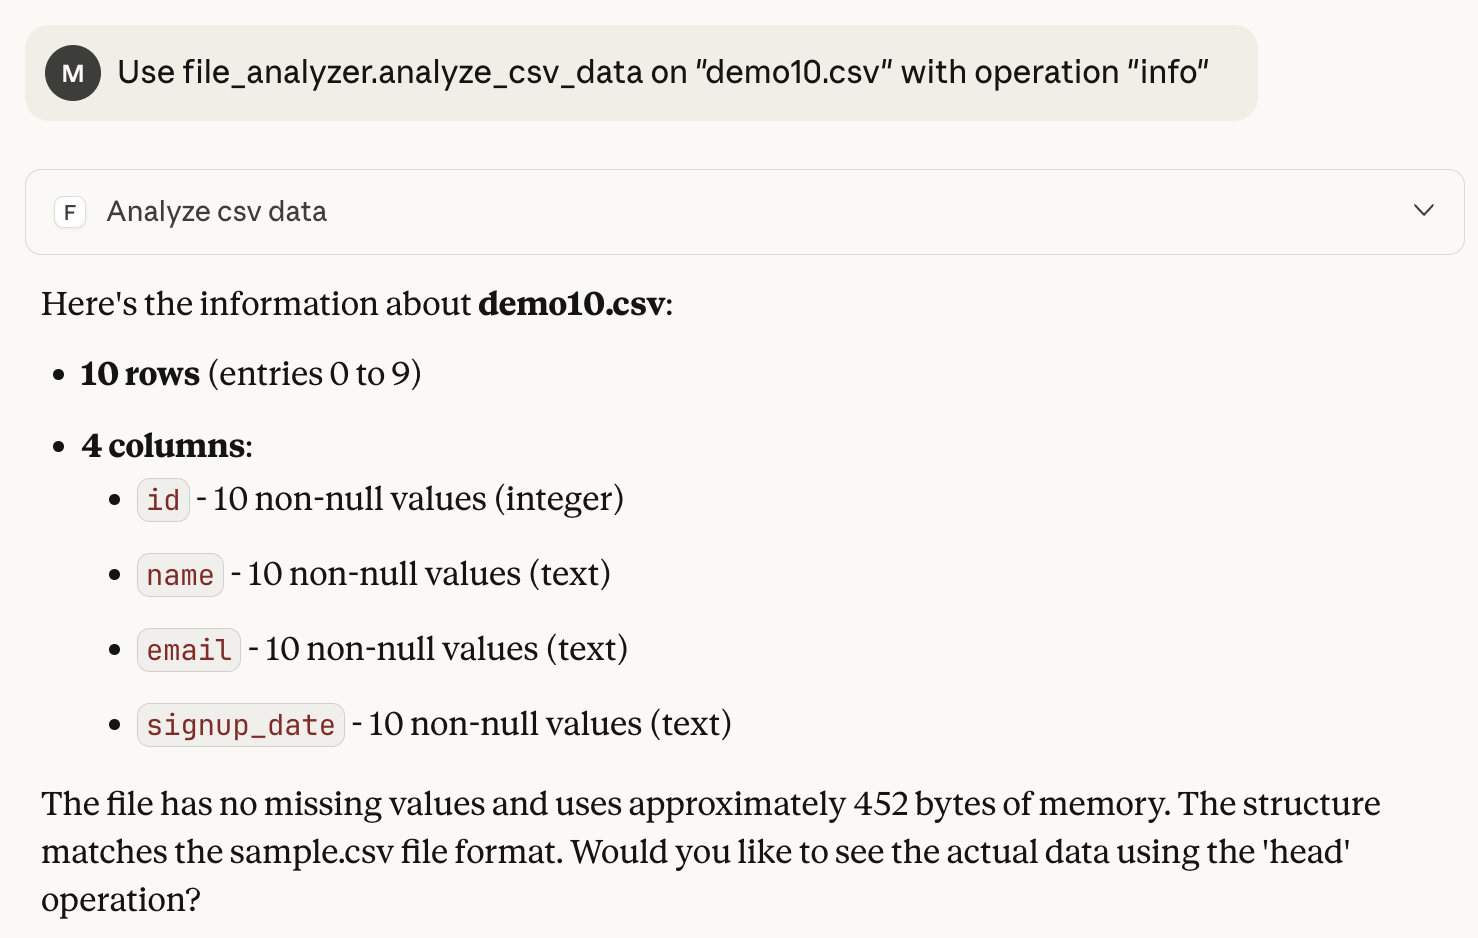

- Error Handling

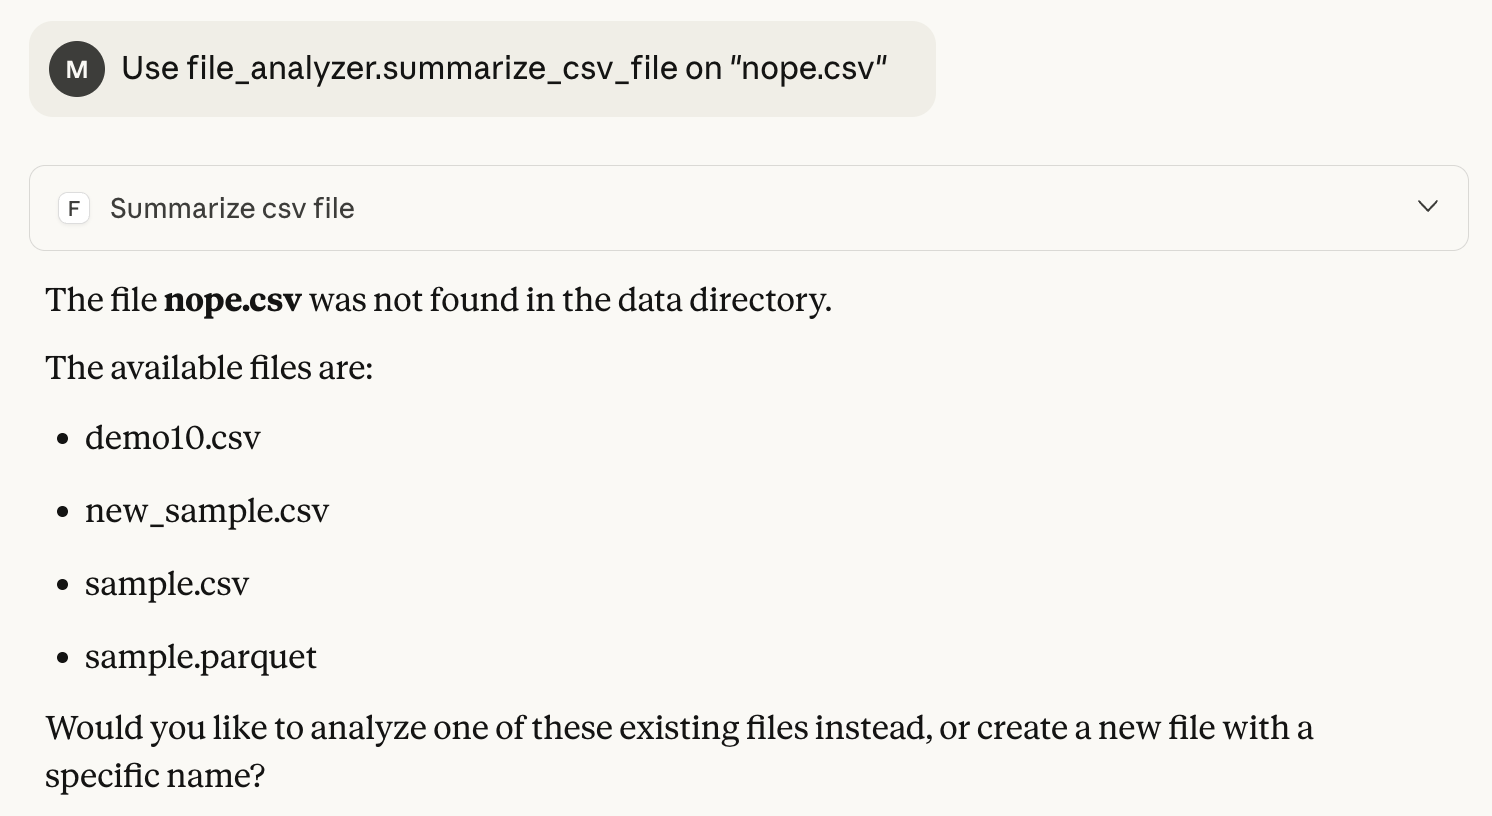

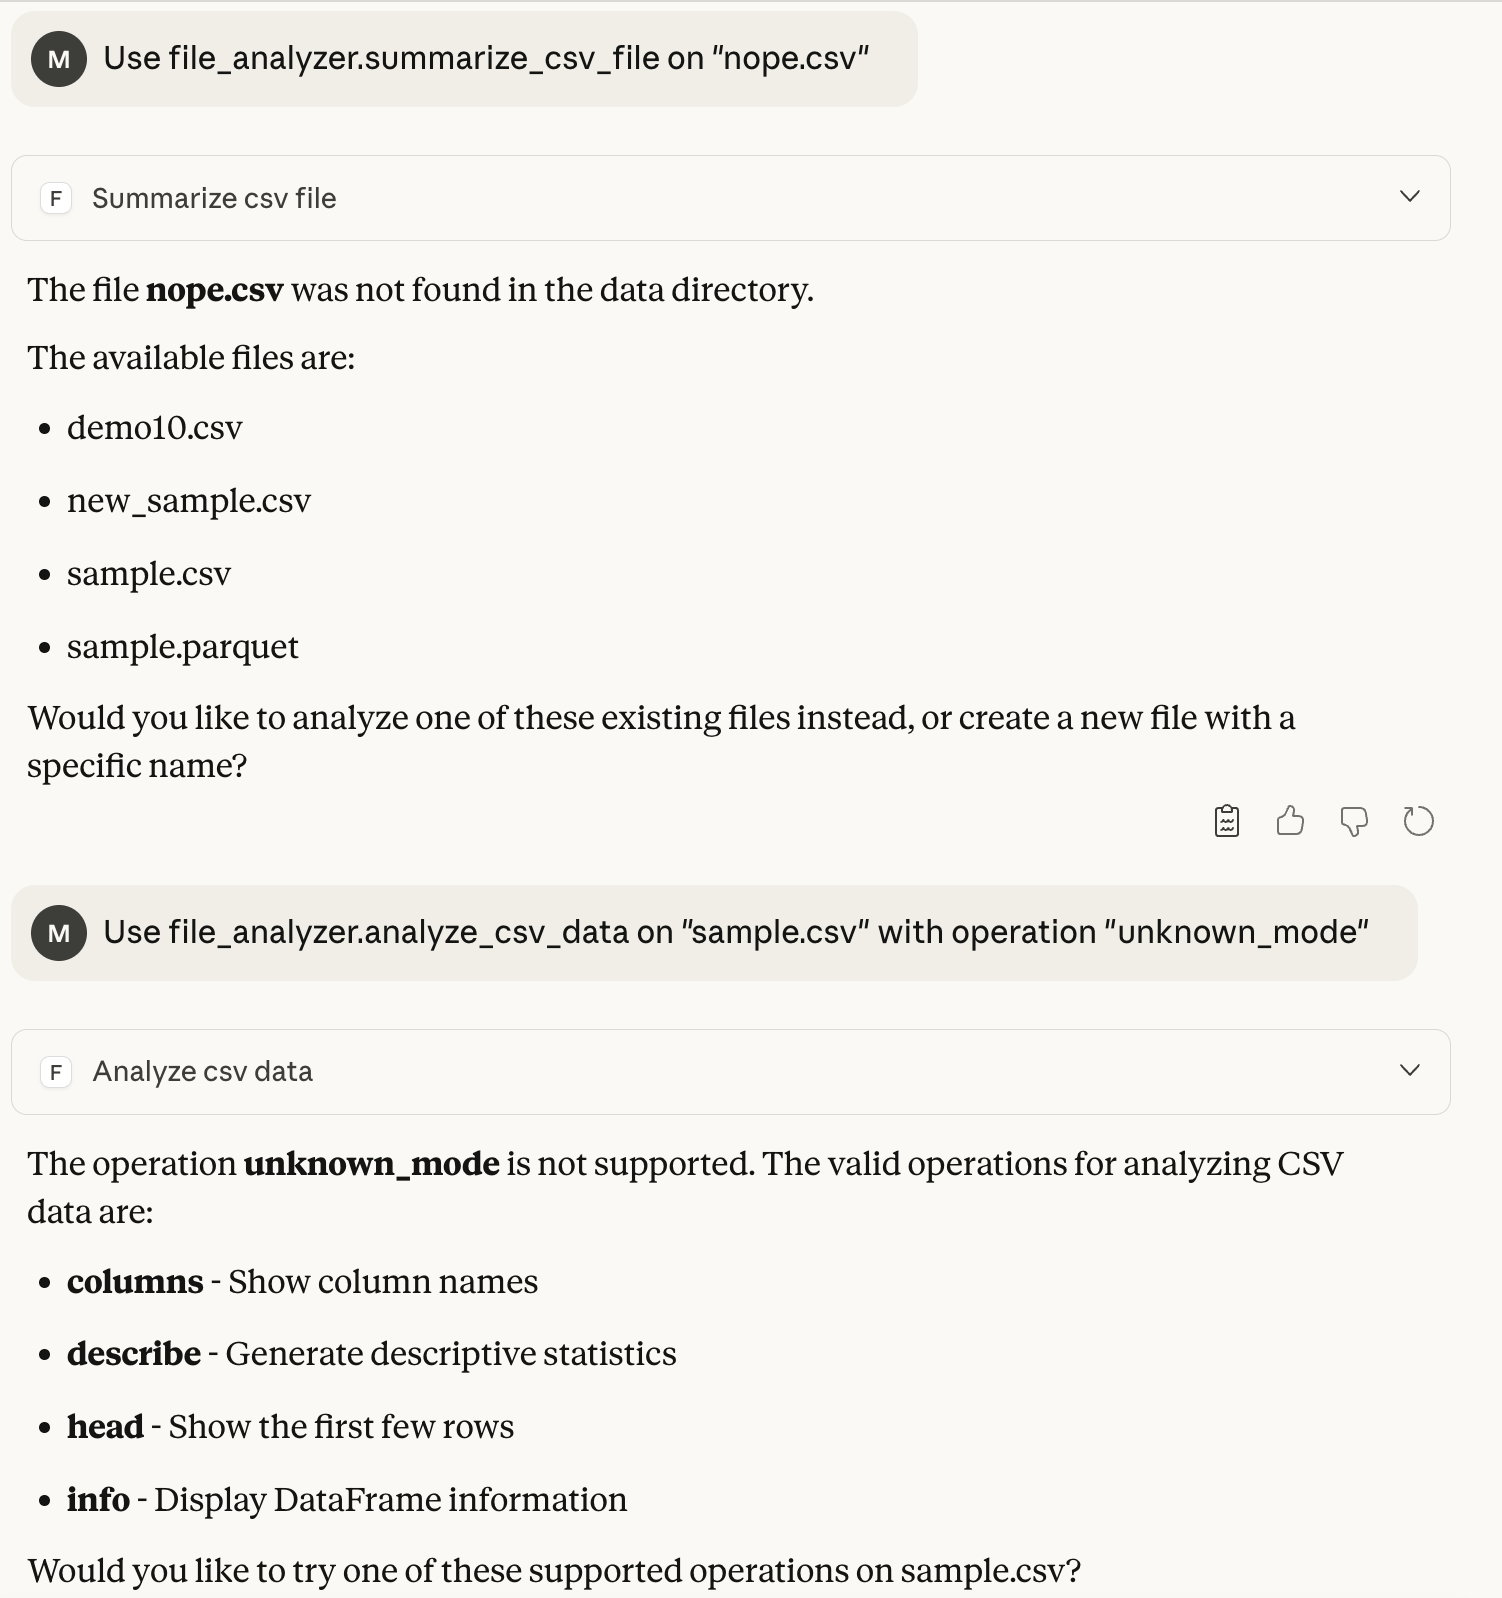

- Multi-step interation test

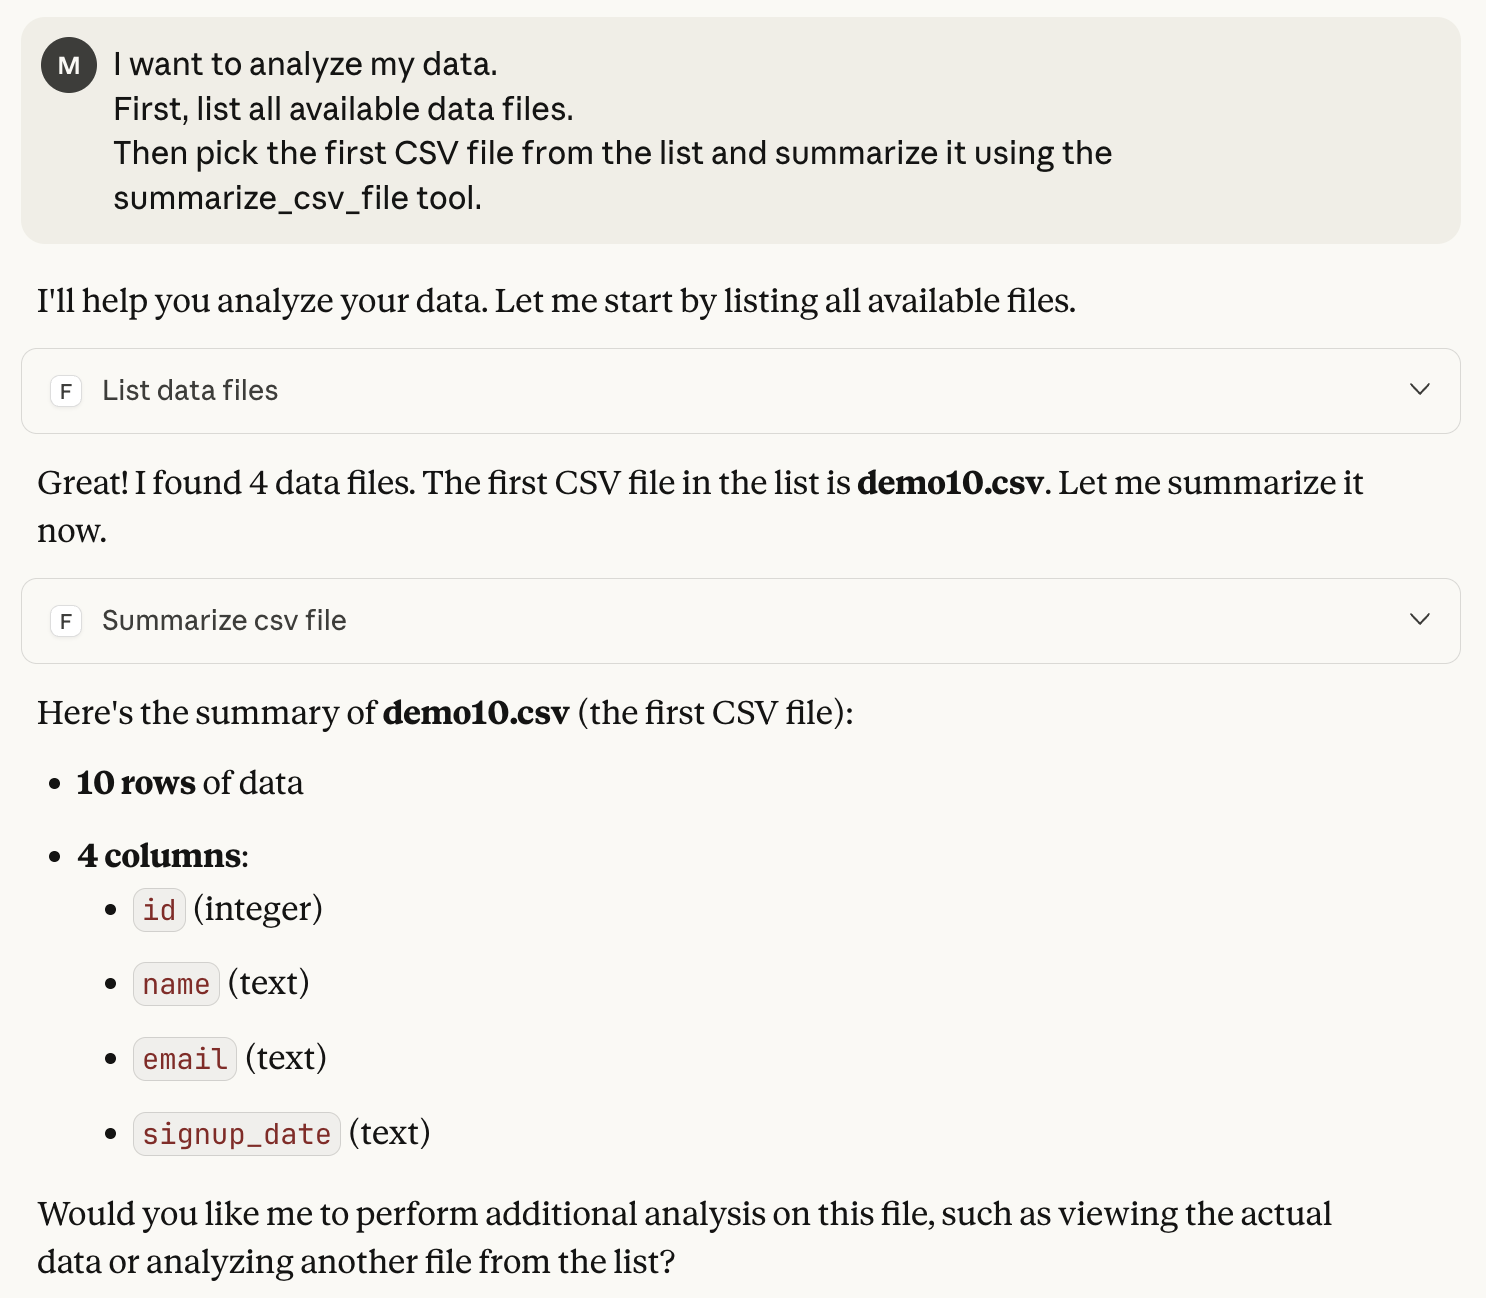

- Response Quality & Accuracy Evaluation

Claude Desktop demonstrated strong accuracy and reliability across all natural-language interaction tests. For basic operations such as listing files and summarizing CSV data, Claude consistently returned results that matched the actual contents of the data directory and the underlying dataset schema. Multi-step prompts were also handled correctly: Claude was able to infer the sequence of operations, retrieve the appropriate file, and execute the requested analysis without requiring additional clarification. Error-handling behavior was accurate and user-friendly; when given invalid filenames or unsupported analysis modes, Claude produced clear diagnostic messages and suggested valid alternatives. Overall, Claude’s responses were precise, context-aware, and aligned with the expected behavior of the implemented MCP server, confirming that the integration works reliably under both normal and edge-case conditions.

### 3 Performance Analysis and Comparison (2 points)
- Compare response times between direct client calls and Claude Desktop integration
- Analyze the effectiveness of natural language vs. programmatic tool invocation
- Evaluate the user experience and practical applications of the MCP integration
- Discuss limitations and potential improvements for the system

In comparing the direct MCP client with the Claude Desktop integration, the difference in response time was clear. The direct client communicates with the server over stdio and returns results almost immediately. Claude Desktop, however, is slower because each request goes through an additional reasoning step before the tool is invoked. The underlying MCP execution time is the same, but the extra interpretation layer adds noticeable latency.

Both interfaces produced correct outputs, but they differed in how they handled errors and ambiguous inputs. The programmatic client is strict and returns errors directly when given invalid parameters. Claude, by contrast, is more flexible: it can interpret incomplete or slightly incorrect instructions, ask clarification questions, and chain multiple operations through natural-language reasoning. This makes the Claude integration more accessible, especially for users who are not familiar with specific tool names or parameters.

From a user-experience perspective, the direct client is fast and predictable, which is useful for debugging and controlled testing. Claude Desktop offers a more intuitive interface for exploratory analysis, since it provides explanations rather than only raw output and allows users to request multi-step analyses naturally. Once the environment was configured correctly, interacting with the MCP server felt smooth, although the initial setup required resolving version mismatches between Python and the MCP package.

There are still limitations. For the Claude Integration, Natural-language reasoning introduces latency, and Claude occasionally misinterprets vague prompts. In contrast, for the direct client (MCP itself), the system currently supports only CSV and Parquet files and lacks optimizations for large datasets. Setup and documentation could also be improved to reduce friction for new users. One positive aspect is that the MCP server is fully open-source and free to use, which makes experimentation easy and lowers the barrier to extending or customizing the system. Future improvements such as broader file-format support, clearer error messages, and reduced latency would make the integration more robust.